# FHDW Master - Forecasting
# Time Series Forecasting on Departments in Stores

## Loading packages and modules

### Integrated Python Packages

In [1]:
import os
import gc
import warnings
import re
from time import time
from datetime import datetime
import math

### Packages for Working with Datasets and Calculations

In [2]:
import pandas as pd
import numpy as np

### Packages for Forecasting

In [3]:
import mlforecast
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

### Hyperparameter Tuning and Error Metrics

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

### Visualization Packages

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

In [ ]:
from statsmodels.tsa.seasonal import MSTL
from scipy.signal import periodogram

## Analysis of Main Dataset

### Loading Train Dataset and first look

In [ ]:
train = pd.read_parquet("../data/store_sales/train.parquet") # We converted the original files to parquet format to speed up the reading process and reduce the file size
display(train)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


### Getting initial Information about the Dataset

In [ ]:
print("---------------------------------------------------------")
print(train.info())
print("---------------------------------------------------------")
print(train.describe())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(train.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
---------------------------------------------------------
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00

### Converting date to datetime

In [ ]:
train["date"] = pd.to_datetime(train["date"])

### DataFrame Visualization

#### Core Descriptive Numbers

In [ ]:
print(f"Number of Stores: {train['store_nbr'].nunique()}")
print(f"Number of Departments: {train['family'].nunique()}")
print(f"Number of Days in Dataset: {train['date'].nunique()}")
print(f"Total Sales: {train['sales'].sum()}")

Number of Stores: 54
Number of Departments: 33
Number of Days in Dataset: 1684
Total Sales: 1073644952.2030689


#### Analysis of Sales per Department

##### Pie Chart of Distribution of Sales by Department

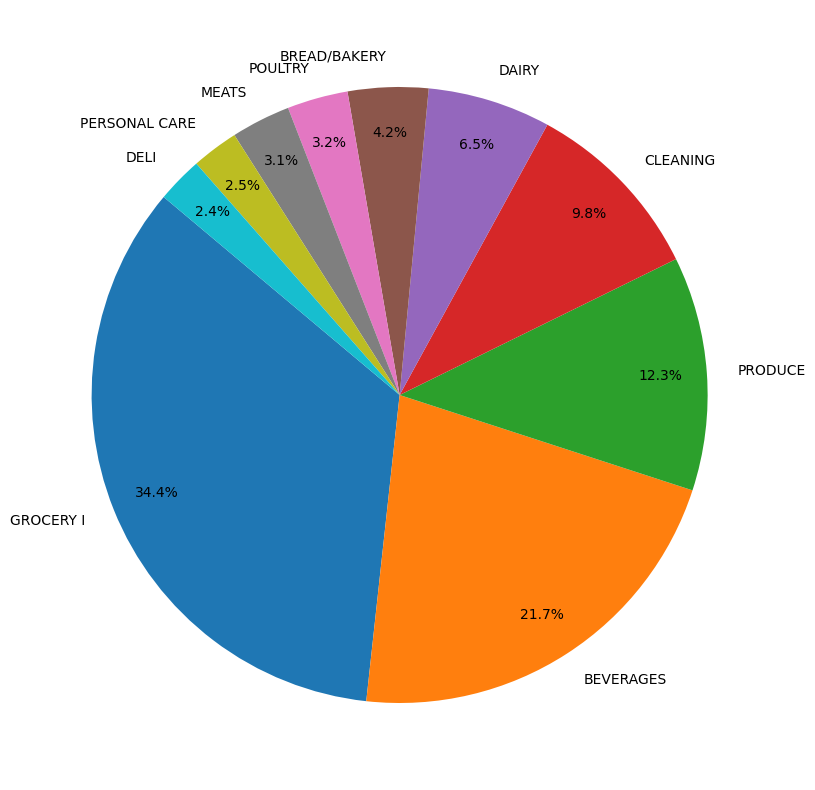

In [ ]:
temp = train.copy()
df_fa_sa = temp.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
fig = plt.figure(figsize=(10, 10))
plt.pie(data=df_fa_sa, x='sales', labels='family', autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.show()

##### Line Plots for every Family of Products

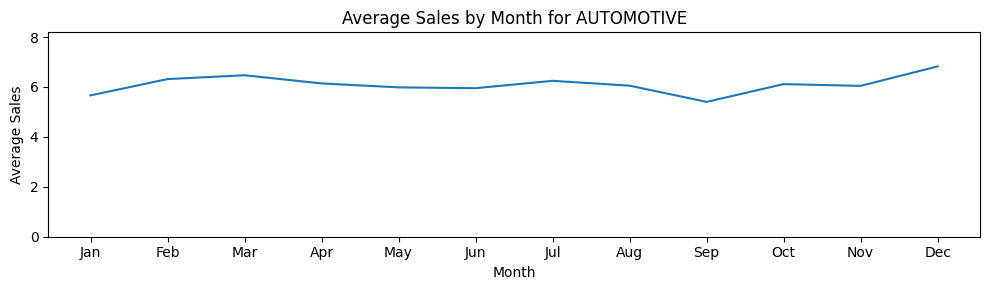

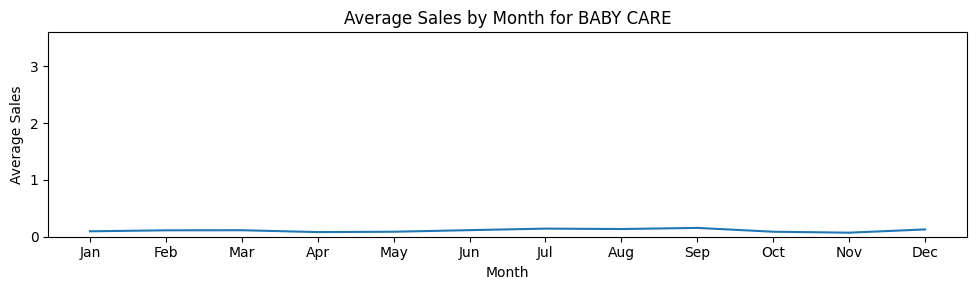

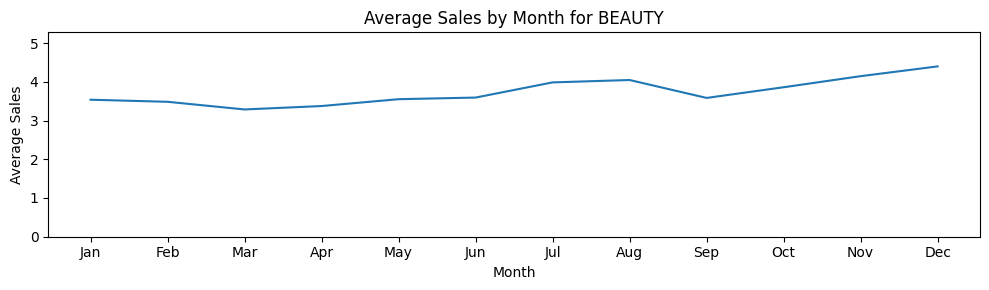

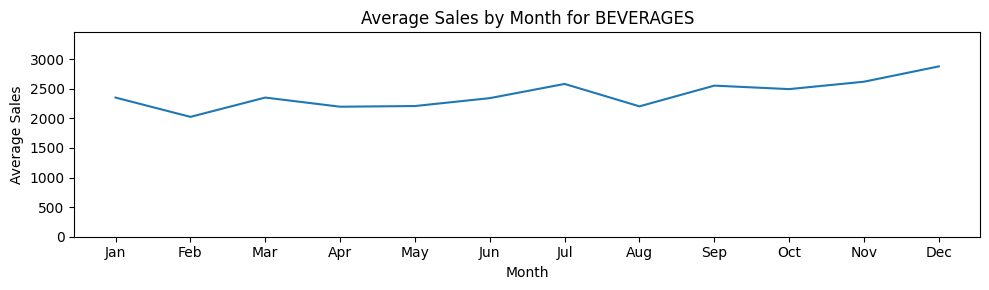

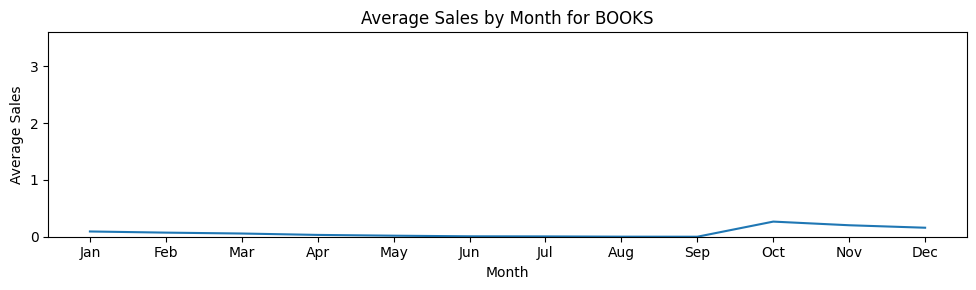

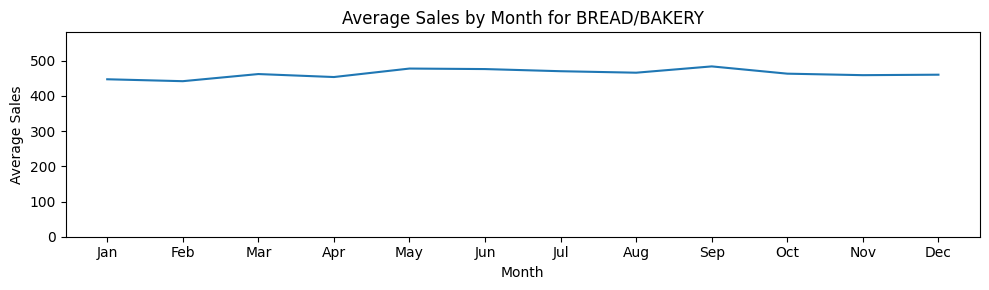

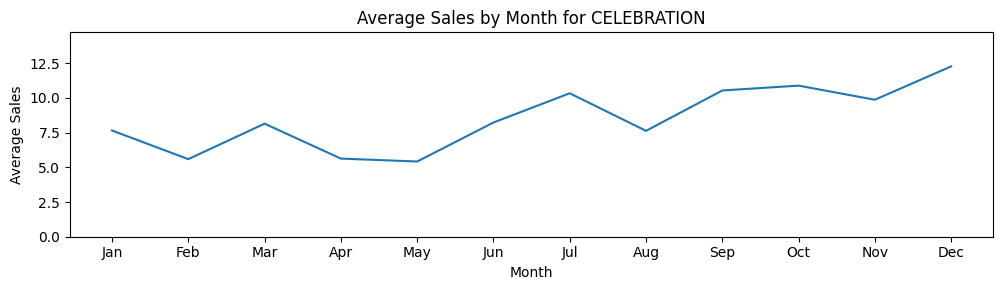

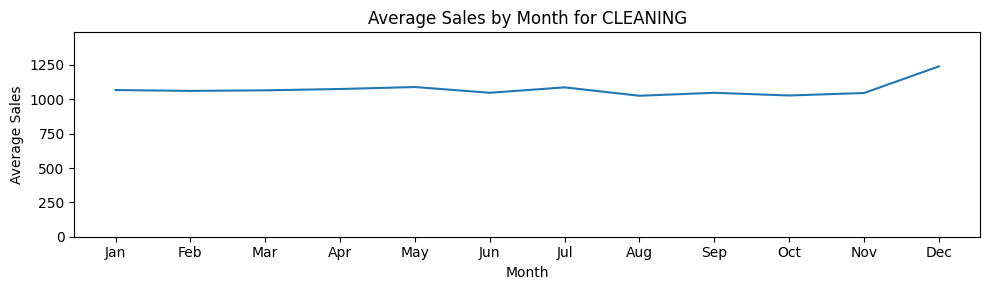

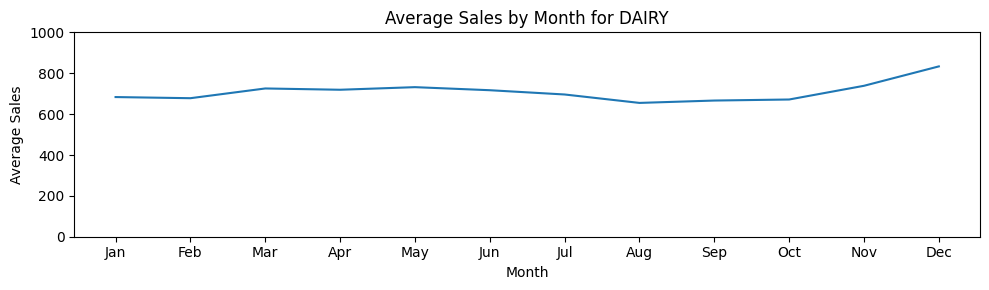

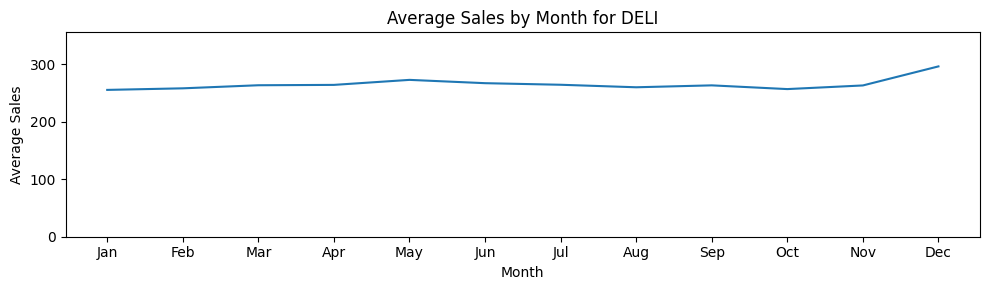

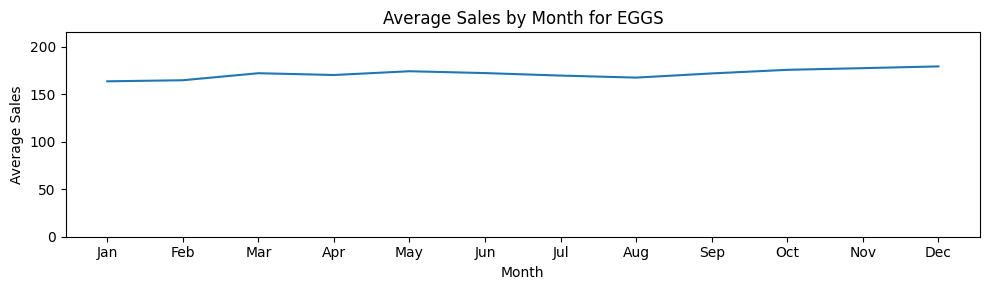

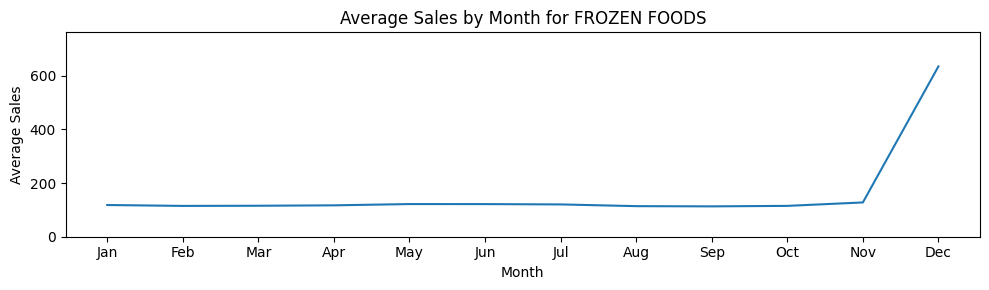

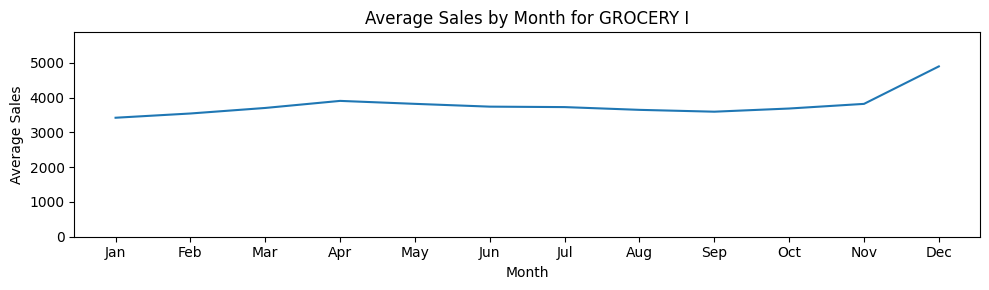

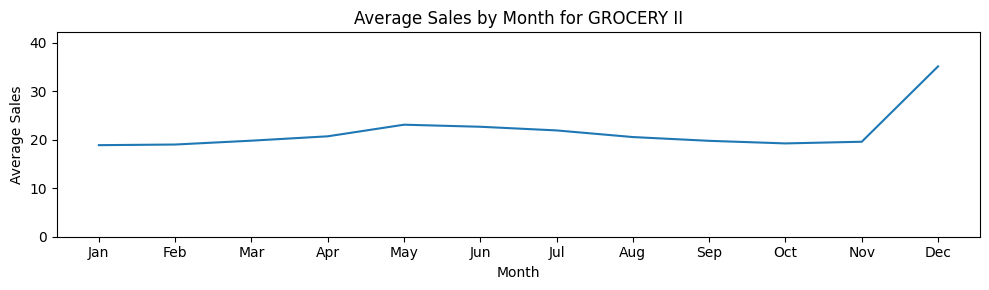

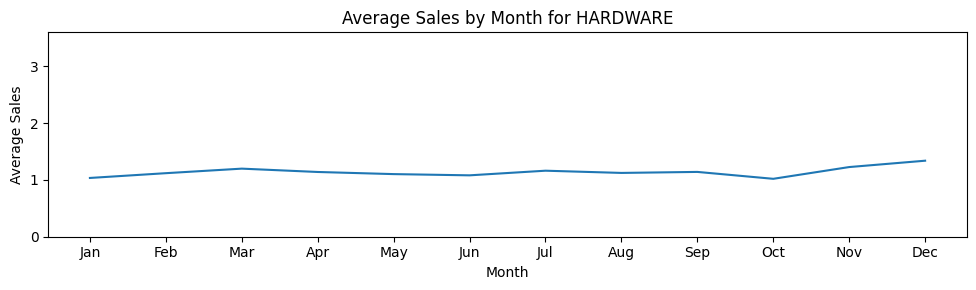

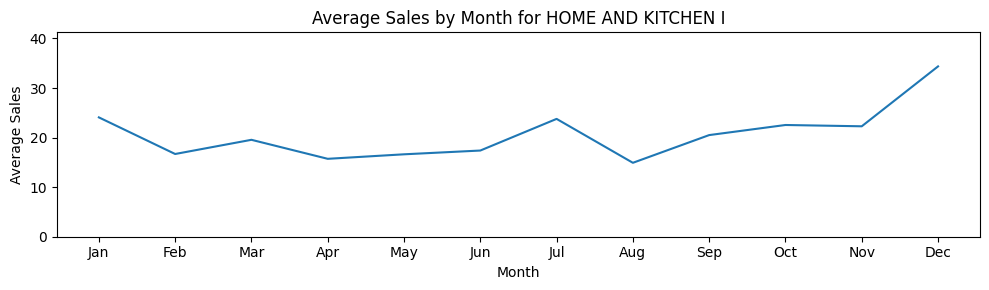

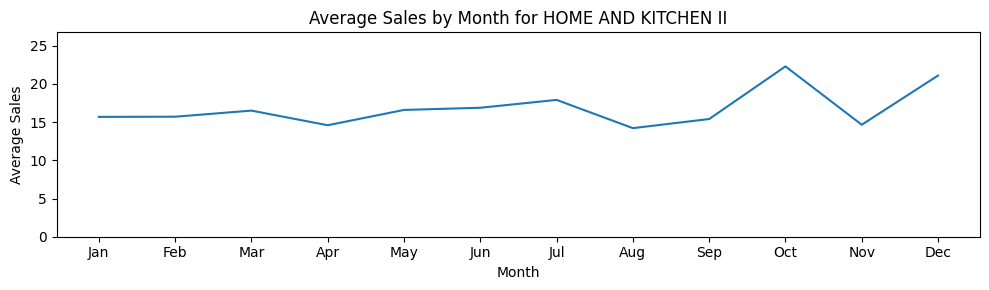

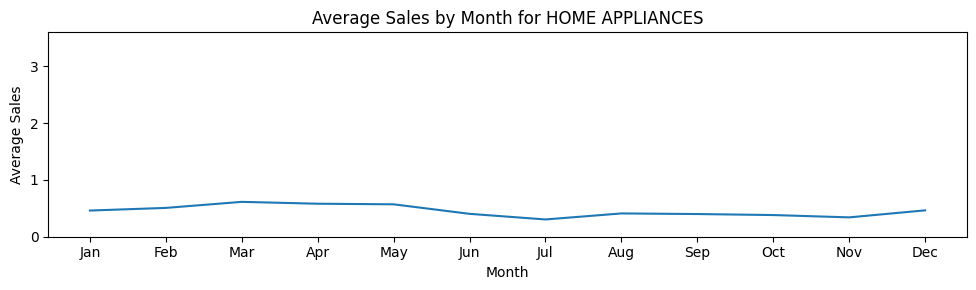

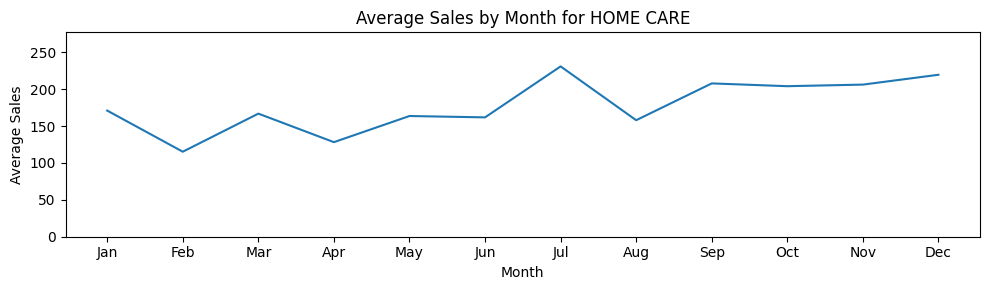

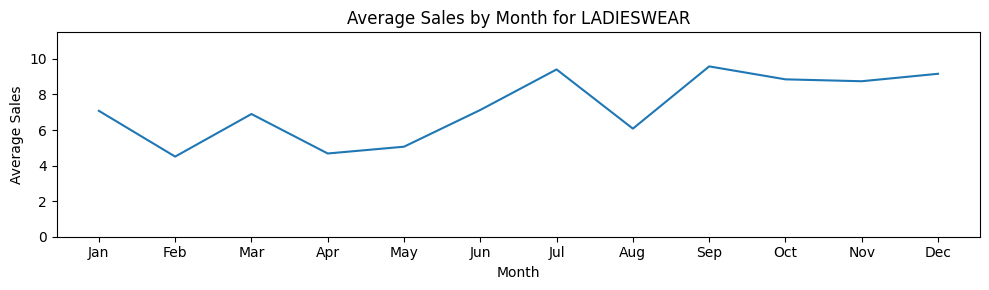

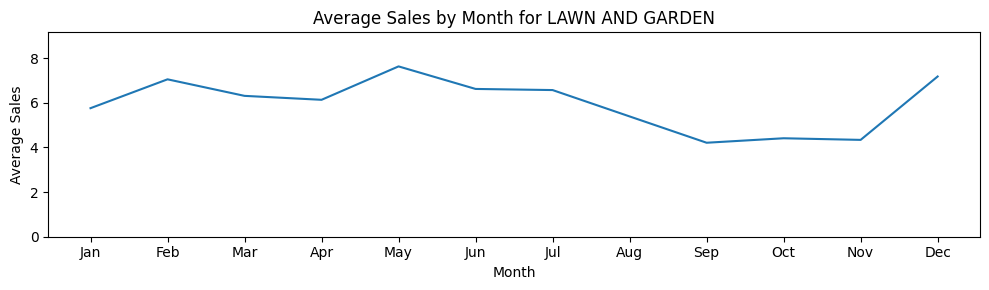

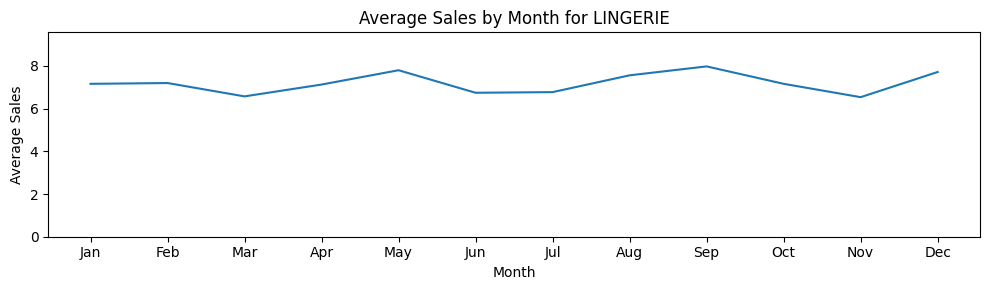

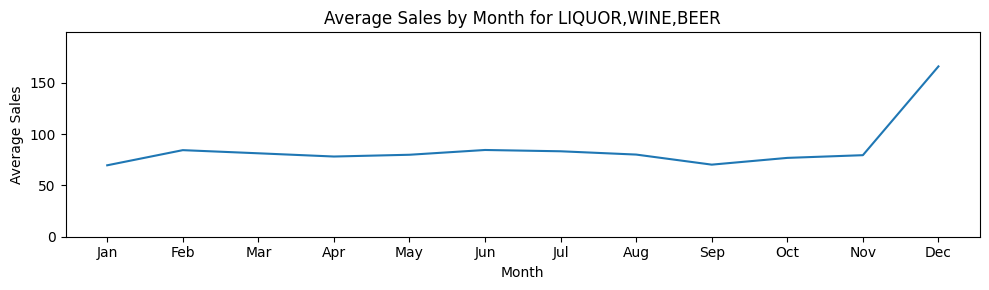

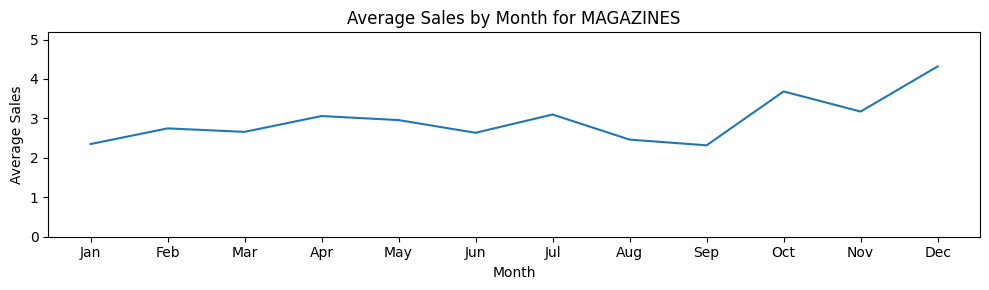

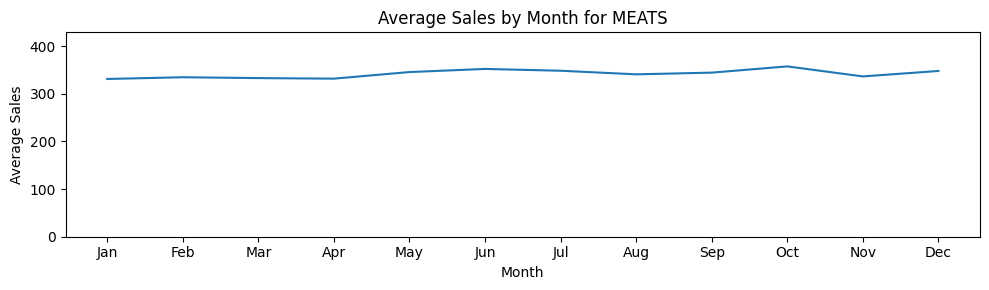

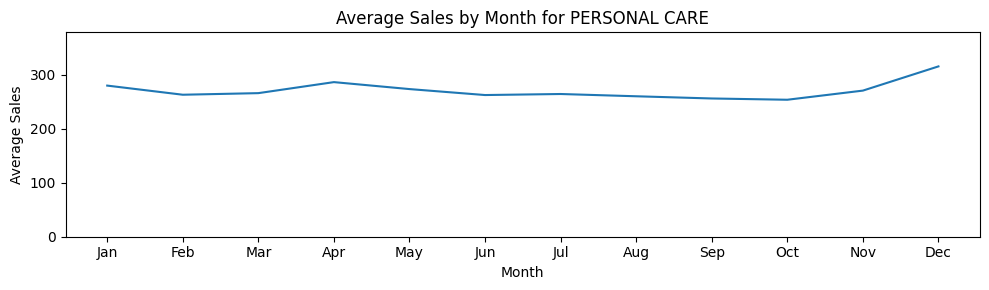

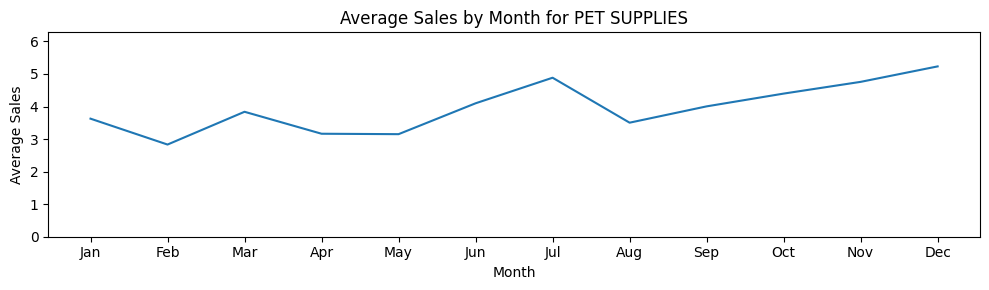

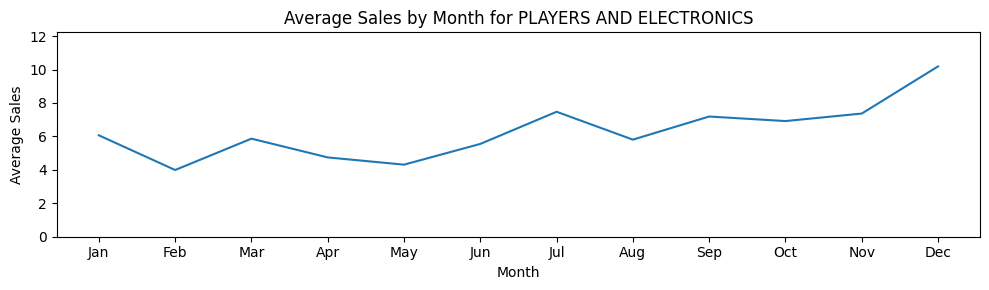

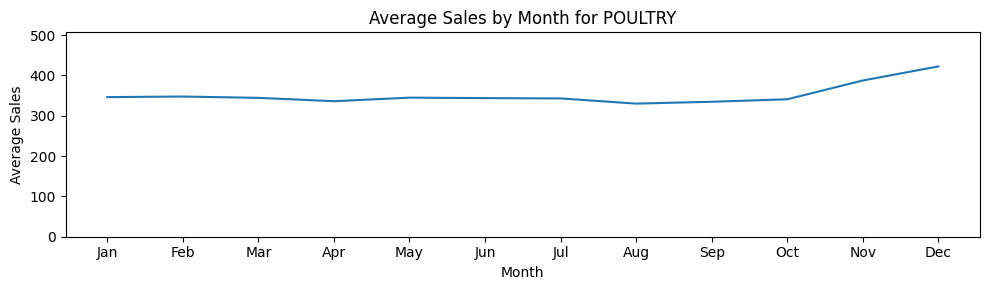

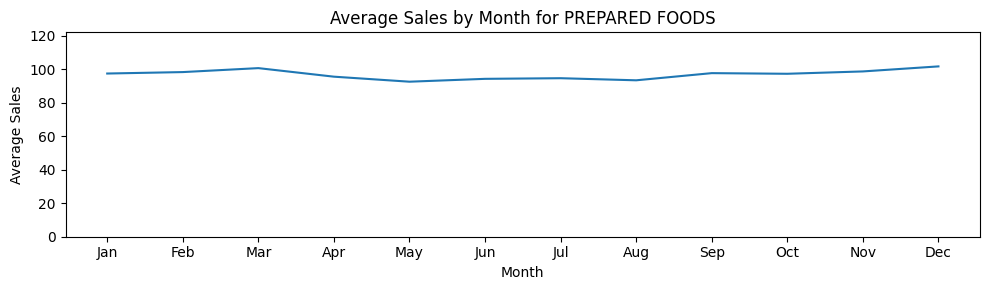

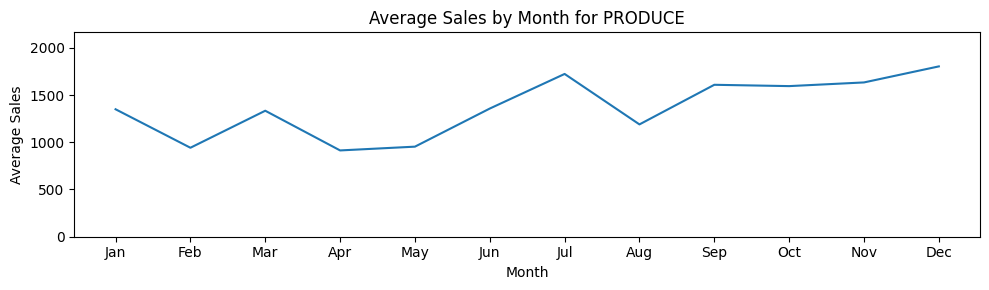

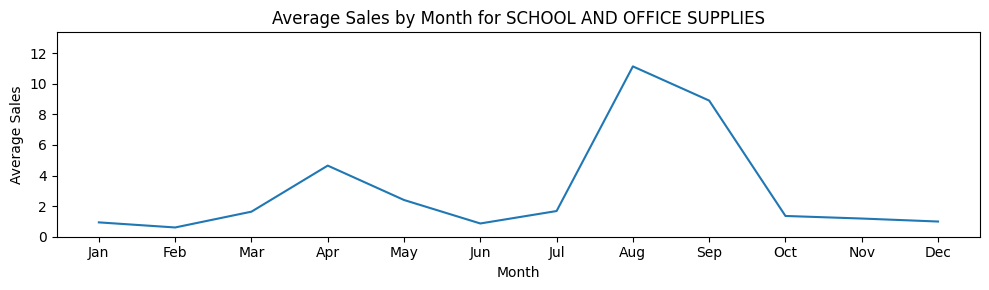

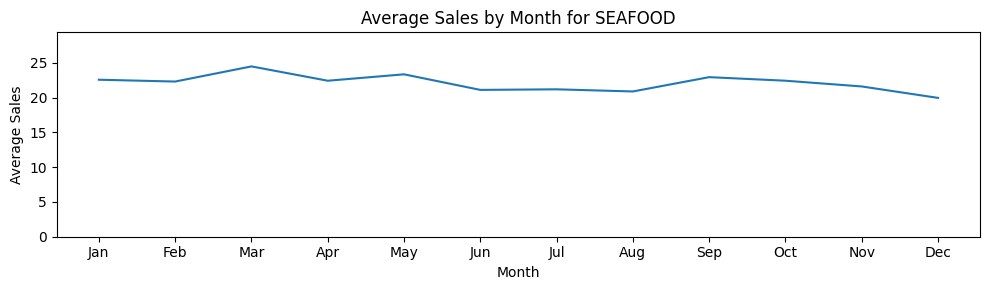

In [ ]:
# Make a copy of the data
temp = train.copy()

# Group the data by month, family, and year, and calculate the average sales
monthly_avg_sales = temp.groupby([temp['date'].dt.month, 'family'])['sales'].mean().reset_index()

# Get unique families
unique_families = monthly_avg_sales['family'].unique()

# Create a separate plot for each family
for family in unique_families:
    # Filter data for the current family
    family_data = monthly_avg_sales[monthly_avg_sales['family'] == family]
    
    
    # Calculate the maximum sales value for this family
    max_sales = family_data['sales'].max()
    
    # If max_sales is too small, adjust it to avoid extreme spikes and pits
    if max_sales < 3:  # You can adjust this threshold as needed
        max_sales = 3
    
    # Create a line plot using Seaborn
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=family_data, x='date', y='sales')
    
    
    
    # Set plot title and labels
    plt.title(f'Average Sales by Month for {family}')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')
    
    # Set the x-axis labels to month names
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    # plt.ylim(0, family_data['sales'].max() * 1.2)
    plt.ylim(0, max_sales * 1.2)

    plt.tight_layout()
    plt.show()


#### Sales in Different Time Intervals

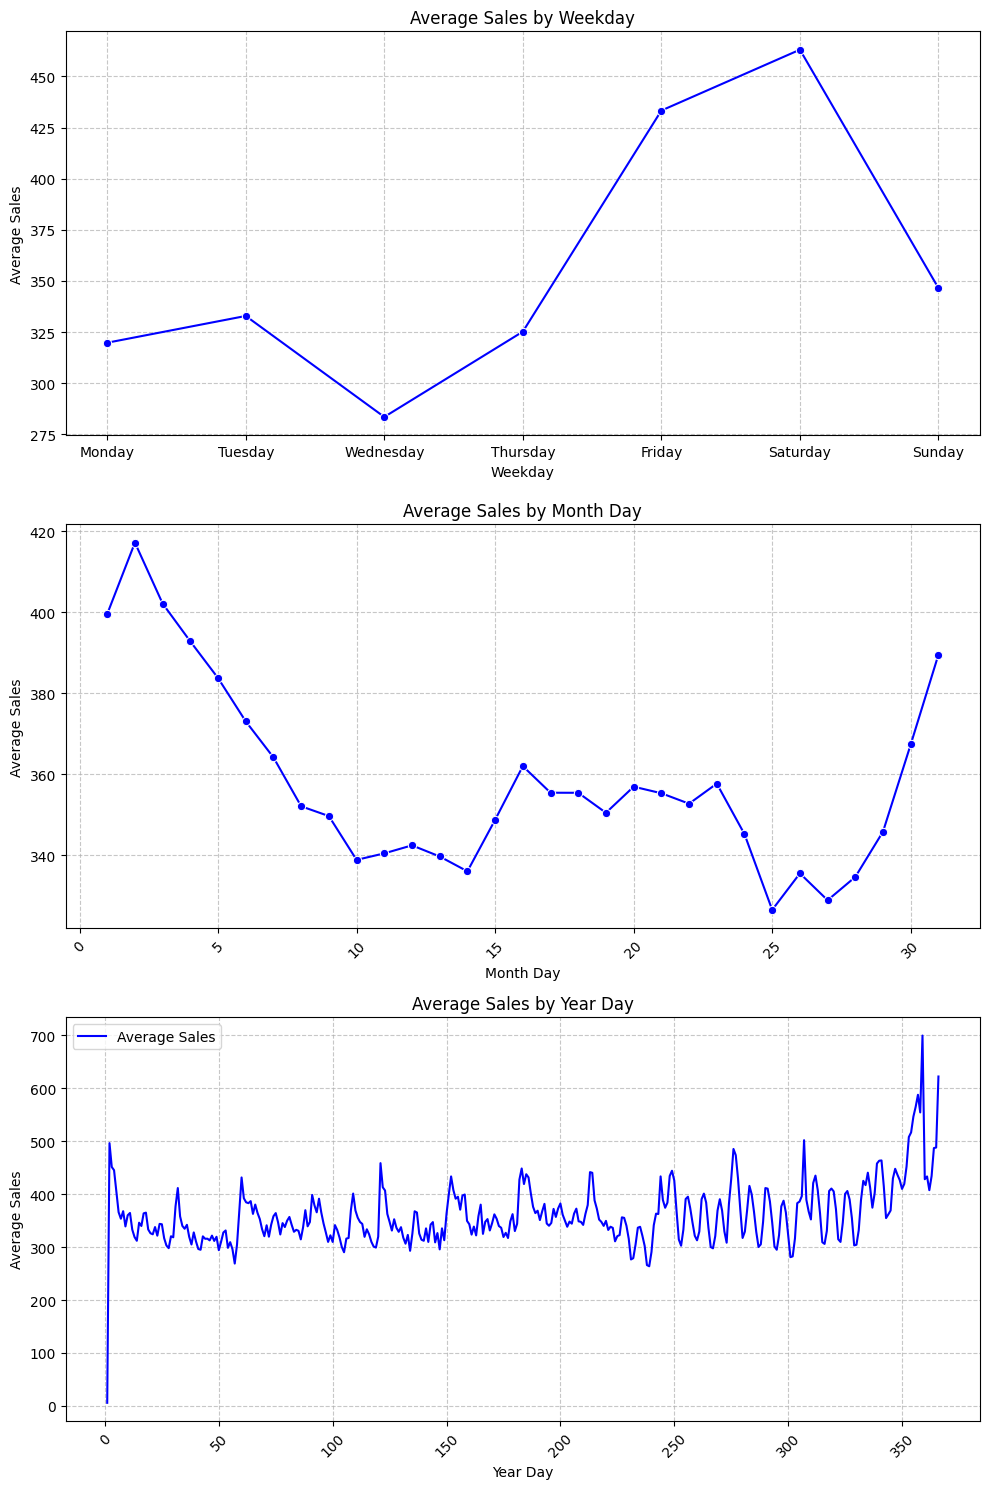

In [ ]:
temp = train.copy()
temp = temp.set_index('date')
temp["week_day"] = temp.index.day_name()
temp["month_day"] = temp.index.day
temp["year_day"] = temp.index.dayofyear

# Create a stacked subplot plot
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1: Average Sales by Weekday
sns.lineplot(data=temp, x='week_day', marker='o', y='sales', errorbar=None, color='blue', ax=axs[0])
axs[0].set_title('Average Sales by Weekday')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Average Sales')
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Average Sales by Month Day
sns.lineplot(data=temp, x='month_day', marker='o', y='sales', errorbar=None, color='blue', ax=axs[1])
axs[1].set_title('Average Sales by Month Day')
axs[1].set_xlabel('Month Day')
axs[1].set_ylabel('Average Sales')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Average Sales by Year Day
sns.lineplot(data=temp, x='year_day', y='sales', errorbar=None, color='blue', label='Average Sales', ax=axs[2])
axs[2].set_title('Average Sales by Year Day')
axs[2].set_xlabel('Year Day')
axs[2].set_ylabel('Average Sales')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


##### Learnings:
- Sales tend to be higher on weekends, especially Saturdays
- Sales are higher on beginning and middle of month (Probably because of biweekly salaries)
- Sales go up at the end of the year

#### Seasonality Analysis

##### Periodogram for Frequency Analysis

New Row Count: 1684


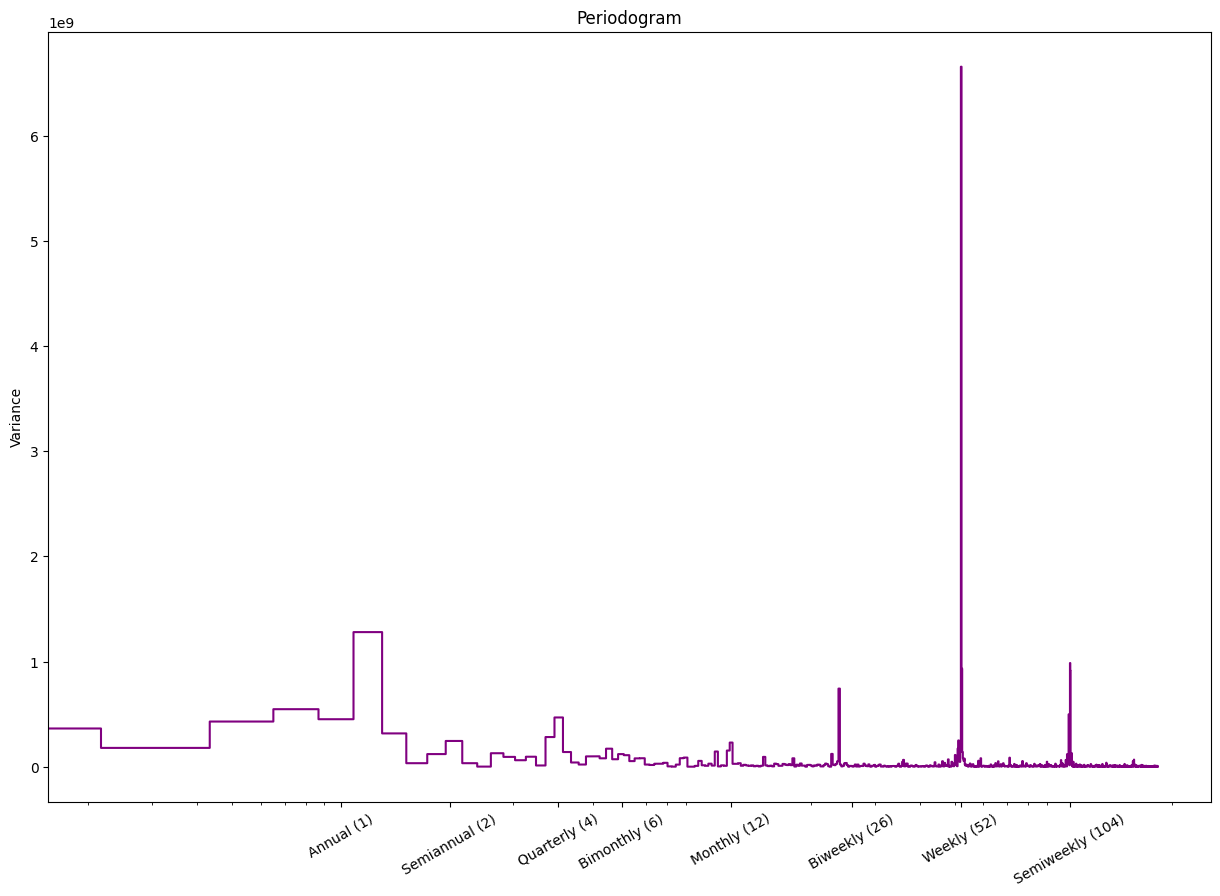

In [ ]:
seasonality_temp_df = train.copy()
seasonality_temp_df = seasonality_temp_df.groupby('date').agg({'sales':'sum'})
print(f"New Row Count: {seasonality_temp_df.shape[0]}")

fs = pd.Timedelta("365D") / pd.Timedelta("1D")
frequencies, spectrum = periodogram(
    seasonality_temp_df.sales,
    fs=fs,
    detrend="linear",
    window="boxcar",
    scaling='spectrum',
)


_, ax = plt.subplots()

ax.step(frequencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

plt.show()

##### Checking if observed Trends are visible using MSTL

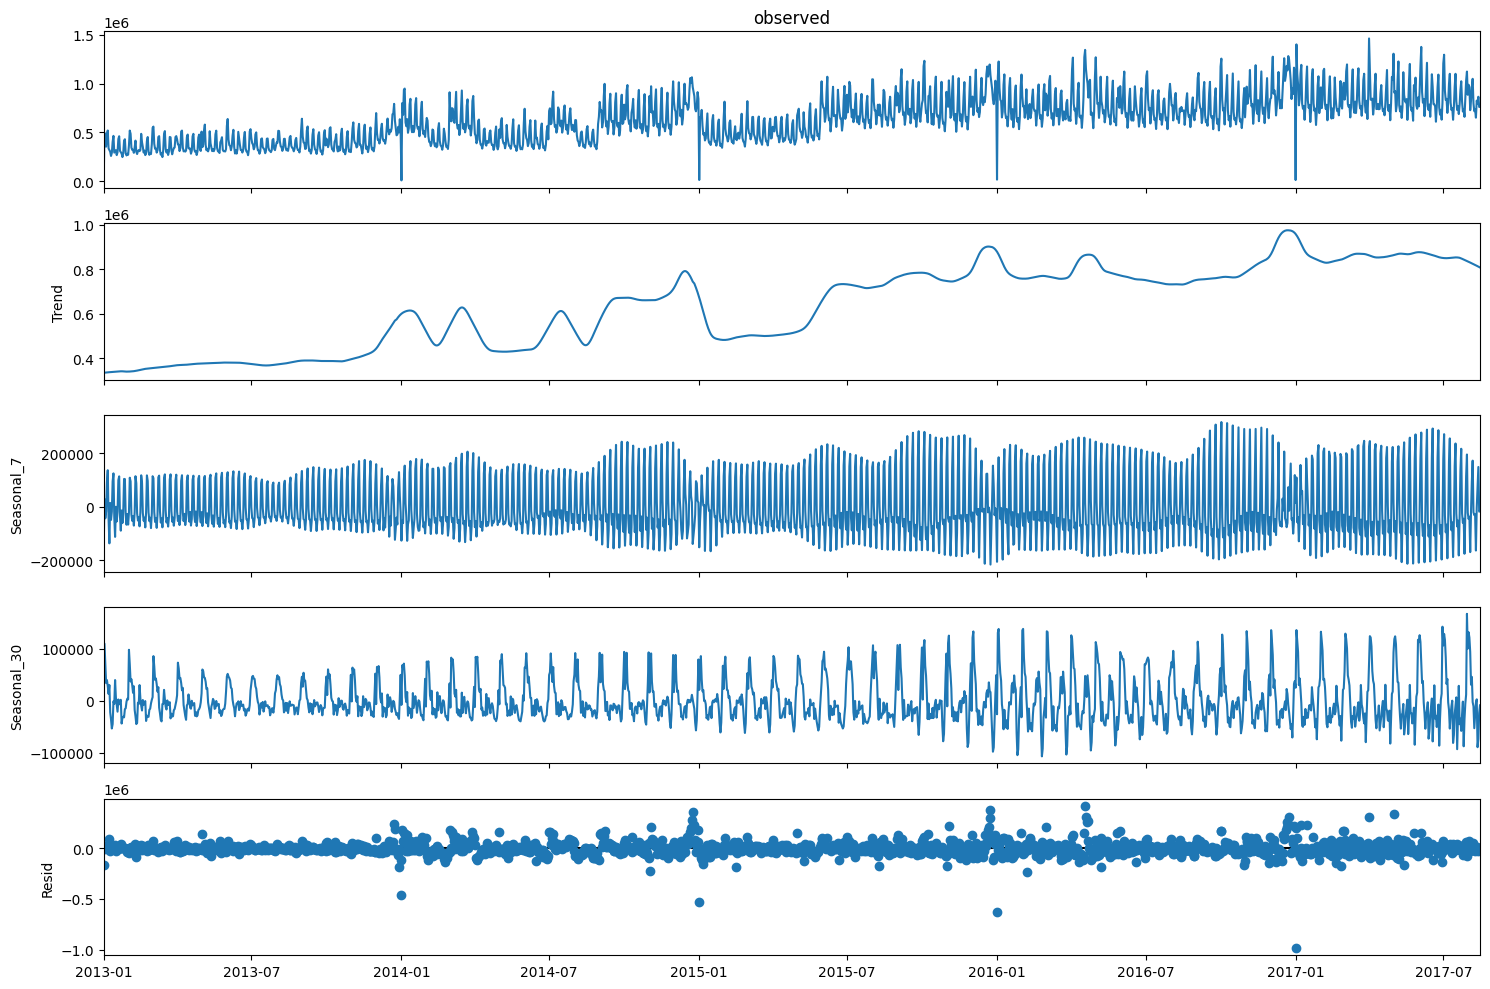

In [ ]:
# Decomposing sales data to check the seasonality in the sales using MSTL from statsmodels library
res = MSTL(seasonality_temp_df['sales'], periods=(7, 30)).fit()
# increase the figure size
plt.rcParams['figure.figsize'] = (15, 10)
# Plot the results
res.plot()
plt.show()

#### Analysis of Individual Stores

##### Monthly Sales per Store

In [ ]:
monthly_sales = train.set_index("date").groupby("store_nbr").resample("ME").agg({"sales": "sum"}).reset_index()
px.line(monthly_sales, x="date", y="sales", color="store_nbr", title="Monthly sales per store")

#### Removing unopened stores

##### Detect Stores which have not been opened yet

We essentially create a new column containing a 'flag' value. \
We start with the flag either on 0, if a store has 0 total sales on the first day, or on 1 if it has. \
For the next day we check again if the store has total sales. 
- If it has total_sales > 0, we set the flag to 1.
- If it has total_sales == 0, we check if the previous flag is 0 or 1.
  - If the previous flag is 0, we set the flag for the day also to 0
  - If the previous flag is 1, we ignore total_sales and set the current flag to 1 

This way, a flag for a store is only 1 before it's first ever sale. 

In [ ]:
detecting_closed_stores = train.copy()
detecting_closed_stores['total_sales'] = detecting_closed_stores.groupby(['date', 'store_nbr'])['sales'].transform('sum')
detecting_closed_stores['has_opened'] = detecting_closed_stores.apply(lambda x: 0 if x['total_sales'] == 0 else 1 if x.name == 0 else (0 if (x['total_sales'] == 0 and detecting_closed_stores.at[x.name - 1, 'has_opened'] == 0) else 1), axis=1)
display(detecting_closed_stores[["date", "store_nbr", "total_sales", "has_opened"]])

,date,store_nbr,total_sales,has_opened
0,2013-01-01,1,0.000,0
1,2013-01-01,1,0.000,0
2,2013-01-01,1,0.000,0
3,2013-01-01,1,0.000,0
4,2013-01-01,1,0.000,0
...,...,...,...,...
3000883,2017-08-15,9,18636.477,1
3000884,2017-08-15,9,18636.477,1
3000885,2017-08-15,9,18636.477,1
3000886,2017-08-15,9,18636.477,1


##### Percentage of Days Open per Store

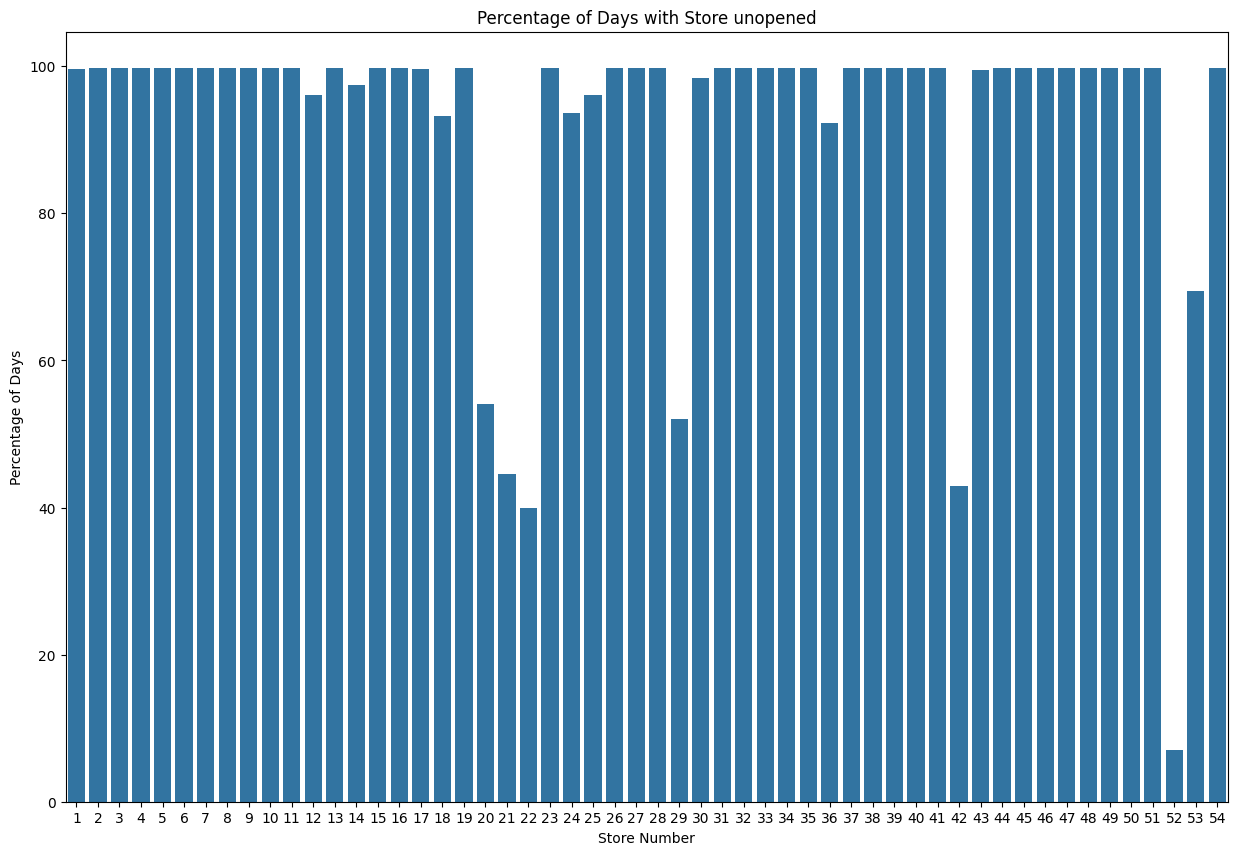

In [ ]:
temp = detecting_closed_stores.copy()
store_days_open = temp[temp['has_opened']==1].groupby('store_nbr')["date"].nunique()
store_percentages = store_days_open / temp["date"].nunique() * 100

sns.barplot(x=store_days_open.index, y=store_percentages)
plt.xlabel('Store Number')
plt.ylabel('Percentage of Days')
plt.title('Percentage of Days with Store unopened')
plt.show()


##### Filter out Stores which are not yet open

In [ ]:
opened_stores_train_df = detecting_closed_stores[detecting_closed_stores["has_opened"]==1]
opened_stores_train_df = opened_stores_train_df.drop(columns=["total_sales", "has_opened"])
print(f"Rows dropped: {detecting_closed_stores.shape[0] - opened_stores_train_df.shape[0]} | {round(((detecting_closed_stores.shape[0] - opened_stores_train_df.shape[0]) / detecting_closed_stores.shape[0]) * 100, 2)} %")

Rows dropped: 241890 | 8.06 %


#### Checking for Outliers in Sales and Promotions

##### Plotting Distribution of Sales and Promotions as BoxPlots

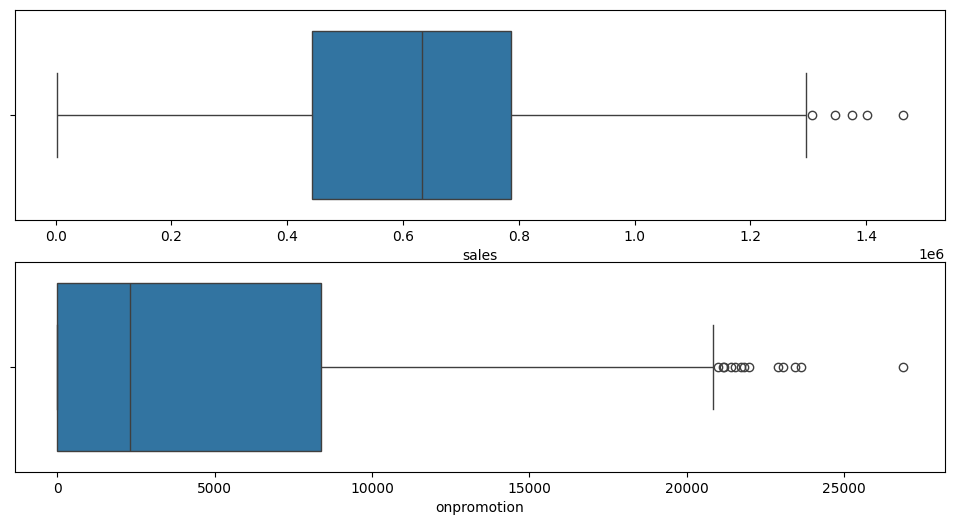

In [ ]:
outliers_temp = opened_stores_train_df.copy()
outliers_temp = outliers_temp.groupby('date').agg({'sales':'sum', 'onpromotion':'sum'}).reset_index()
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sns.boxplot(data=outliers_temp, x='sales', ax=ax[0])
sns.boxplot(data=outliers_temp, x='onpromotion', ax=ax[1])

plt.show()

##### Plotting Promotions and Sales over Time with Highlighted Outliers

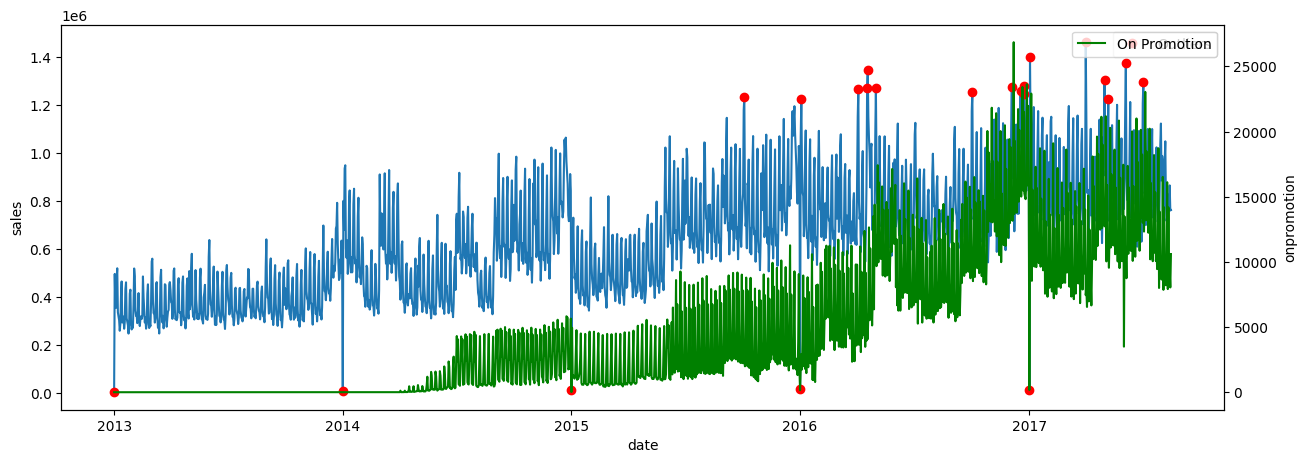

In [ ]:
# Calculating the mean and standard deviation of the sales
mean_sales = outliers_temp['sales'].mean()
std_sales = outliers_temp['sales'].std()

# Seting a threshold for outliers (e.g., 2 standard deviations from the mean)
outlier_threshold = 2.5

# Identifying outliers
outliers = outliers_temp[(outliers_temp['sales'] > mean_sales + outlier_threshold * std_sales) |
                         (outliers_temp['sales'] < mean_sales - outlier_threshold * std_sales)]

# Creating a figure with a primary y-axis for sales
fig, ax1 = plt.subplots(figsize=(15, 5))
sns.lineplot(x='date', y='sales', data=outliers_temp, ax=ax1)
plt.errorbar(x=outliers['date'], y=outliers['sales'], fmt='ro', label='Outliers')
ax1.legend()

# Creating a secondary y-axis for onpromotion
ax2 = ax1.twinx()
sns.lineplot(x=outliers_temp['date'], y=outliers_temp['onpromotion'], data=outliers_temp, ax=ax2, color='green', label='On Promotion')
ax2.legend()

plt.show()

Most Outliers are due to promotions and national events

##### Correlation between Promotions and Sales

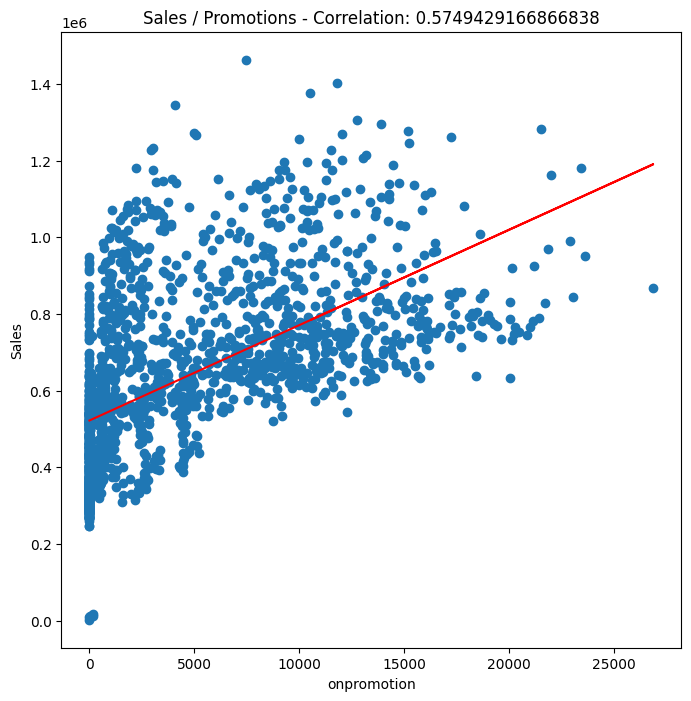

In [ ]:
correlation = outliers_temp['onpromotion'].corr(outliers_temp['sales'])
plt.figure(figsize=(8, 8))
plt.scatter(outliers_temp['onpromotion'], outliers_temp['sales'])
plt.title(f"Sales / Promotions - Correlation: {correlation}")
plt.xlabel("onpromotion")
plt.ylabel("Sales")

# Calculate the coefficients of the polynomial trend line
coefficients = np.polyfit(outliers_temp['onpromotion'], outliers_temp['sales'], 1)
trend_line = np.polyval(coefficients, outliers_temp['onpromotion'])

# Plot the trend line
plt.plot(outliers_temp['onpromotion'], trend_line, color='red')

plt.show()


## Integrating additional Store Data

### Importing Dataset

In [ ]:
stores = pd.read_parquet("../data/store_sales/stores.parquet")
display(stores.head())

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Printing general Overview over Dataset

In [ ]:
print("---------------------------------------------------------")
print(stores.info())
print("---------------------------------------------------------")
print(stores.describe())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(stores.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
---------------------------------------------------------
       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
---------------------------------------------------------
Missing Value Count:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
None
------------------------------

### Merge Store Dataset into Main Dataset

In [ ]:
merged_store_df = pd.merge(opened_stores_train_df, stores, on="store_nbr", how="left")
display(merged_store_df.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1


#### Print Information about merged Dataset

In [ ]:
print("---------------------------------------------------------")
print(merged_store_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(merged_store_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758998 entries, 0 to 2758997
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 210.5+ MB
None
---------------------------------------------------------
Missing Value Count:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64
None
---------------------------------------------------------


### Visualize new Store Information

#### Bar plot of total sales per city

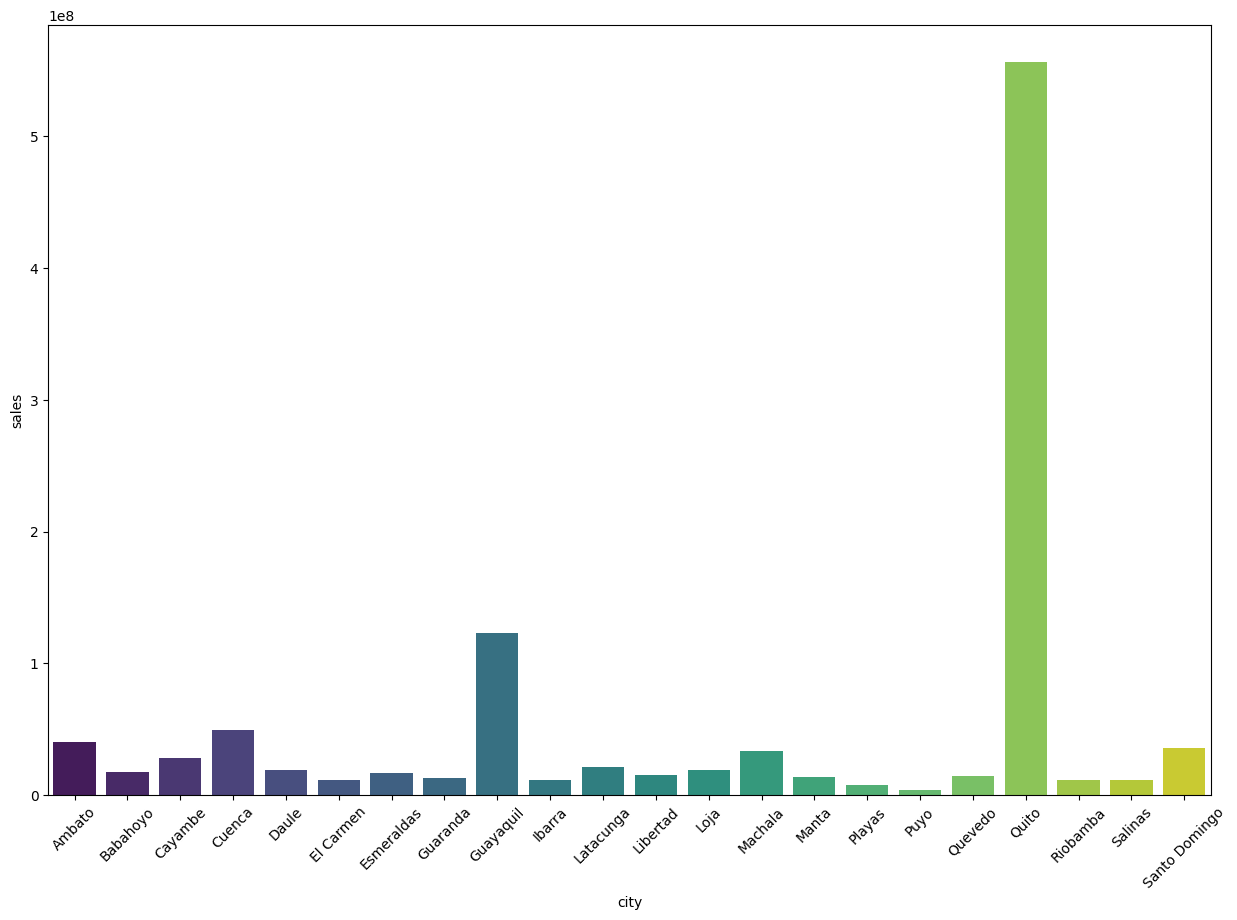

In [ ]:
temp = merged_store_df.copy()
# Plot the data
sns.barplot(data=temp.groupby("city").agg({"sales": "sum"}).reset_index(), x="city", y="sales", hue="city", legend=False, palette="viridis")
plt.xticks(range(len(temp['city'].unique())), rotation=45)
plt.show()


#### Visuals on Cities

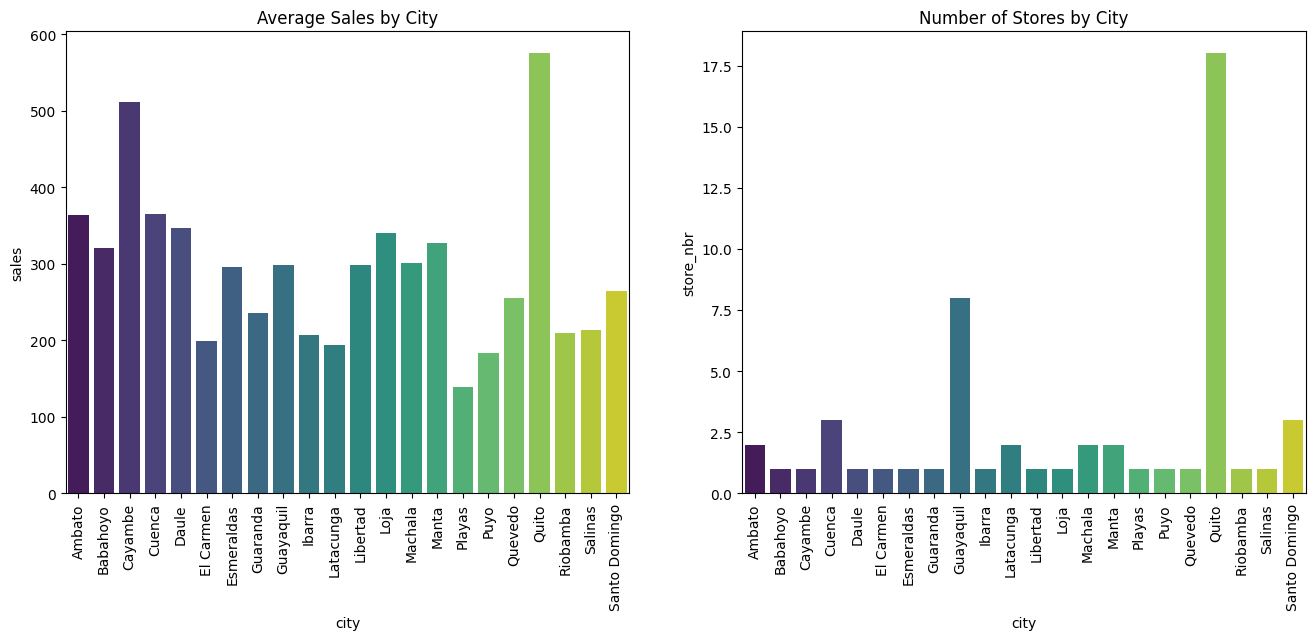

In [ ]:
temp = merged_store_df.copy()
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=temp.groupby(['city']).sales.mean().reset_index(), x='city', y='sales', hue="city", legend=False, palette='viridis')
plt.title('Average Sales by City')
ax1.set_xticks(range(len(temp['city'].unique())))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)  # Set x-axis tick labels rotation to 0 degrees

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=temp.groupby(['city'])['store_nbr'].nunique().reset_index(), x='city', y='store_nbr', hue="city", legend=False, palette='viridis')
plt.title('Number of Stores by City')
ax2.set_xticks(range(len(temp['city'].unique())))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)  # Set x-axis tick labels rotation to 0 degrees

plt.show()


#### Visuals on Clusters / Types of Stores

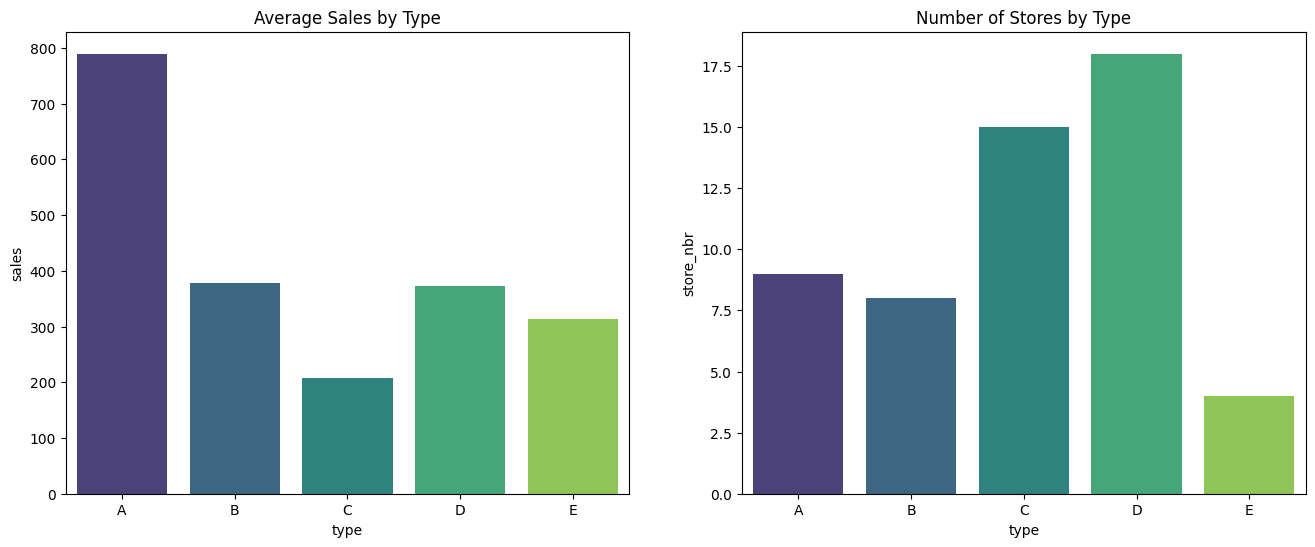

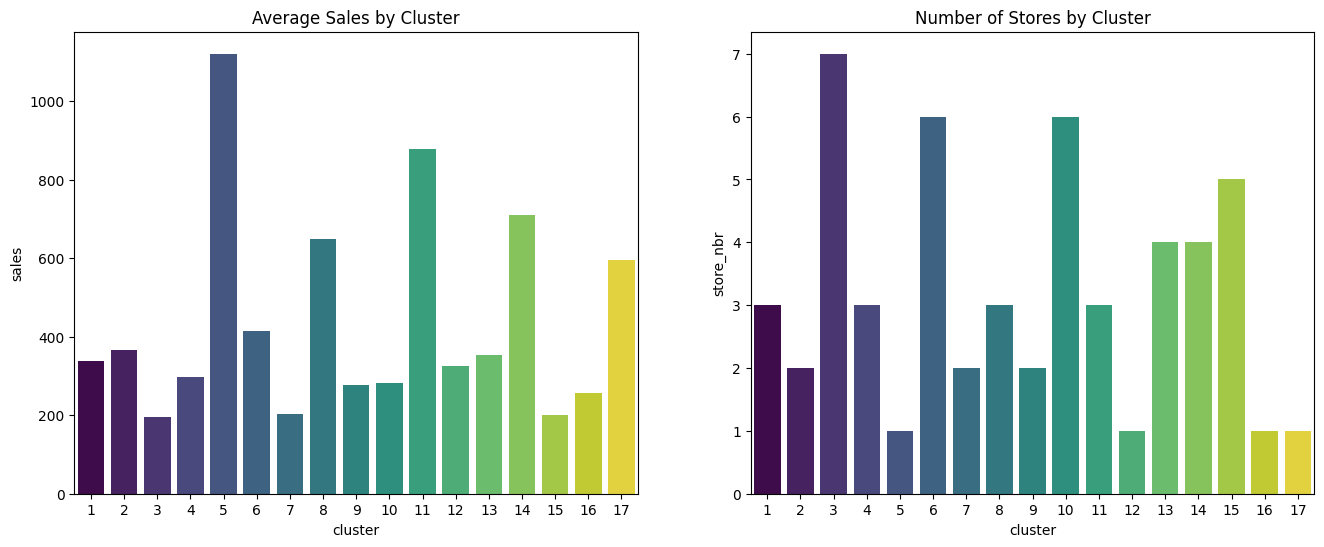

In [ ]:
temp = merged_store_df.copy()
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=temp.groupby(['type']).sales.mean().reset_index(), x='type', y='sales', hue="type", legend=False, palette='viridis')
plt.title('Average Sales by Type')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=temp.groupby(['type'])['store_nbr'].nunique().reset_index(), x='type', y='store_nbr', hue="type", legend=False, palette='viridis')
plt.title('Number of Stores by Type')

plt.show()

plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=temp.groupby(['cluster']).sales.mean().reset_index(), x='cluster', y='sales', hue="cluster", legend=False, palette='viridis')
plt.title('Average Sales by Cluster')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=temp.groupby(['cluster'])['store_nbr'].nunique().reset_index(), x='cluster', y='store_nbr', hue="cluster", legend=False, palette='viridis')
plt.title('Number of Stores by Cluster')

plt.show()


#### Visuals on Type by Year / Month

In [ ]:
temp = merged_store_df.copy()
temp["year"] = temp["date"].dt.year
temp["month"] = temp["date"].dt.month
df_y_m_st = temp.groupby(['year','month','type']).agg({"sales" : "mean"}).reset_index()
df_y_m_st['sales'] = round(df_y_m_st['sales'], 2)

# chart
fig = px.scatter(df_y_m_st, x='month', y='type', color='sales', size='sales', 
                 facet_row='year', title='Average Sales: Store Type Vs Year / Month')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, width=1200, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))

fig.show()

## Integration of Transaction Data for every Store into Main Dataset

### Importing new Transaction Dataset

In [ ]:
transactions = pd.read_parquet("../data/store_sales/transactions.parquet")
display(transactions.head())

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


#### Printing Information about Transaction Dataset

In [ ]:
print("---------------------------------------------------------")
print(transactions.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(transactions.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None
---------------------------------------------------------
Missing Value Count:
date            0
store_nbr       0
transactions    0
dtype: int64
None
---------------------------------------------------------


#### Converting Date column to datetime

In [ ]:
transactions["date"] = pd.to_datetime(transactions.date)

#### Total transactions per store

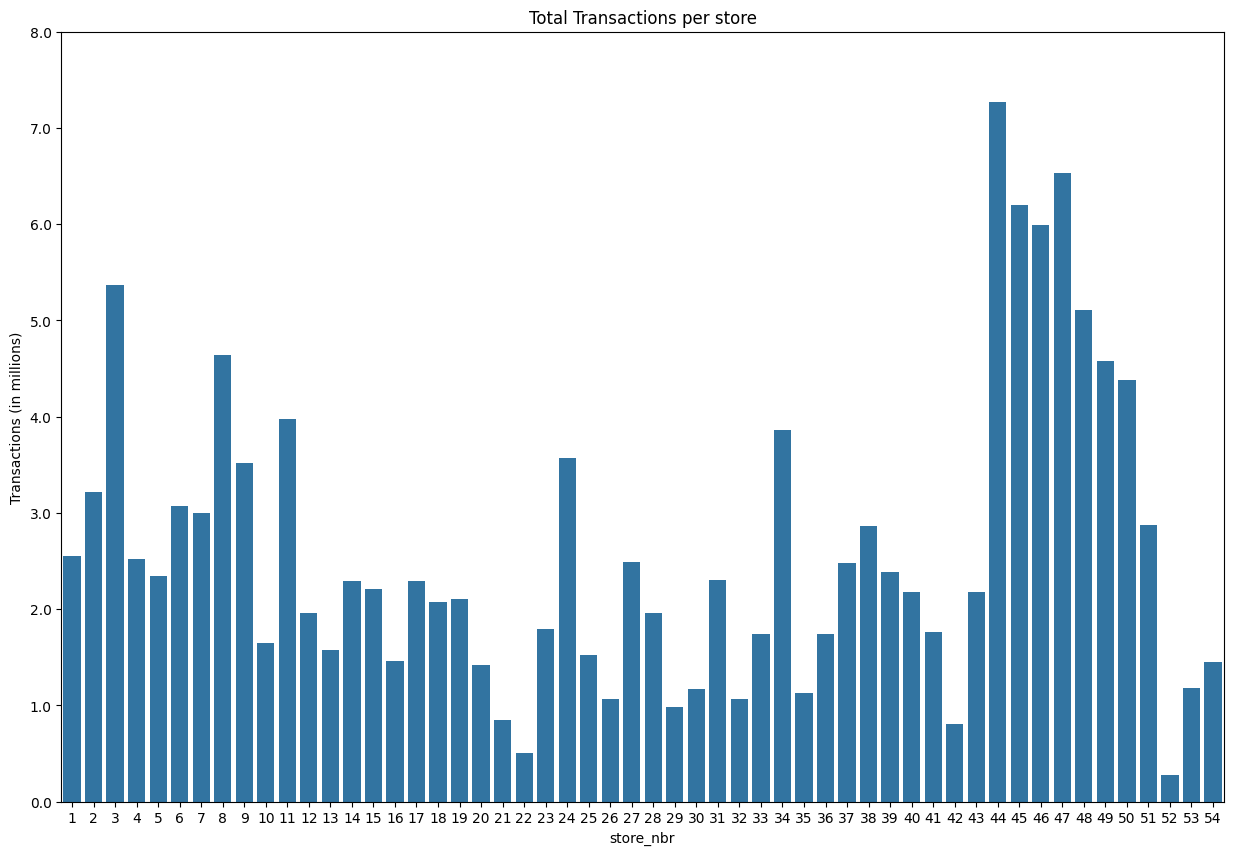

In [ ]:
import seaborn as sns
temp = transactions.copy()

# group by store_nbr and calculate the sum of transactions
grouped_df = temp.groupby("store_nbr").agg({"transactions": "sum"}).reset_index()

# plot the bar chart using seaborn
ax = sns.barplot(data=grouped_df, x="store_nbr", y="transactions")
plt.title("Total Transactions per store")
plt.ylabel("Transactions (in millions)")
ax.set_yticks(range(0, (grouped_df["transactions"].max() + 1000000), 1000000))
ax.set_yticklabels(ax.get_yticks() / 1000000)
plt.show()



#### Transactions per store per month

In [ ]:
temp = transactions.copy()
transactions_temp = temp.set_index("date").groupby("store_nbr").resample("ME").agg({"transactions": "sum"}).reset_index()
px.line(transactions_temp, x="date", y="transactions", title="Transactions per store", color="store_nbr")

### Merge Transaction Dataset into Main Dataset

In [ ]:
merged_transaction_df = pd.merge(merged_store_df.sort_values(["date", "store_nbr"]), transactions, on=["date", "store_nbr"], how = "left")
display(merged_transaction_df.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770.0
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770.0
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770.0
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770.0
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770.0


#### Print Information about Merged Dataset

In [ ]:
print("---------------------------------------------------------")
print(merged_transaction_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(merged_transaction_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758998 entries, 0 to 2758997
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  transactions  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 231.5+ MB
None
---------------------------------------------------------
Missing Value Count:
id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
transactio

#### Filling Missing Values in Transactions using Custom Method

On some of the dates for a particular store we can find sales but zero values for transactions. \
This can only be an mistake, which we need to keep in mind. \
We can also not use simple imputation methods or forward/backwards fill, because they would not keep stores separate from one another. \
This is why we use a custom method here.

##### Creating new Column "total_sales"

In [ ]:
merged_transaction_df['total_sales'] = merged_transaction_df.groupby(['date', 'store_nbr'])['sales'].transform('sum')

##### Filling Missing Values for total_sales == 0

In [ ]:
merged_transaction_df.loc[merged_transaction_df['total_sales'] == 0, 'transactions'] = merged_transaction_df.loc[merged_transaction_df['total_sales'] == 0, 'transactions'].fillna(0)
print(f"NaN Values in Column transactions: {merged_transaction_df['transactions'].isnull().sum()}")

NaN Values in Column transactions: 3894


##### Filling Missing Values for total_sales > 0

Calculating ratio between total_sales and transactions for a day

In [ ]:
merged_transaction_df['sales_transactions_ratio'] = merged_transaction_df['total_sales'] / merged_transaction_df['transactions']
print(f"Max Items sold per Transaction: {merged_transaction_df['sales_transactions_ratio'].max()}")
print(f"Average Items sold per Transaction: {merged_transaction_df['sales_transactions_ratio'].mean()}")
print(f"Min Items sold per Transaction: {merged_transaction_df['sales_transactions_ratio'].min()}")

Max Items sold per Transaction: 2770.9510000000005
Average Items sold per Transaction: 7.463892307618399
Min Items sold per Transaction: 1.9948955034832172


Visualizing ratio using boxplot

<Axes: xlabel='sales_transactions_ratio'>

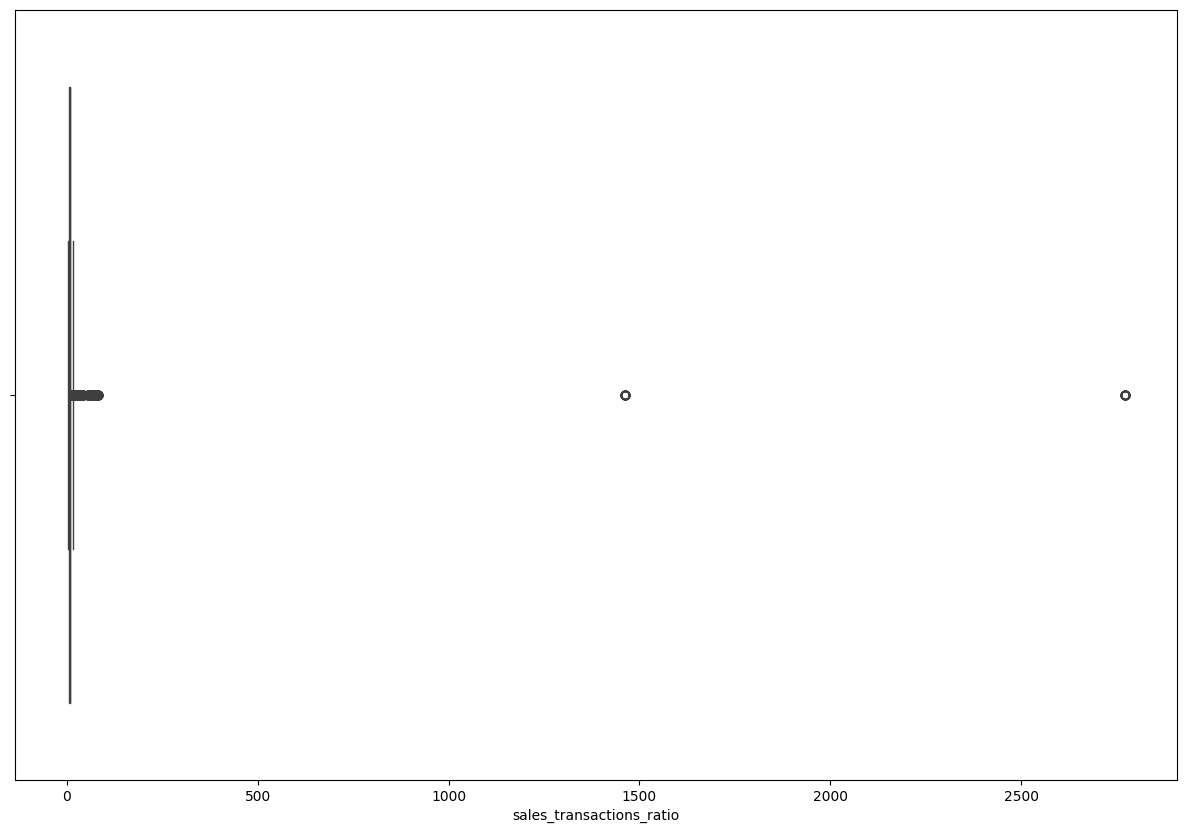

In [ ]:
sns.boxplot(data=merged_transaction_df, x='sales_transactions_ratio')

Calculating median ratio to get less impact from outliers

In [ ]:
median_ratio = merged_transaction_df['sales_transactions_ratio'].median()
print(f"Median Items sold per Transaction: {median_ratio}")

Median Items sold per Transaction: 7.156389264410902


Filling missing values by dividing total_sales with median_ratio

In [ ]:
merged_transaction_df['transactions'] = merged_transaction_df['transactions'].fillna(merged_transaction_df['total_sales'] / median_ratio)
merged_transaction_df['transactions'] = merged_transaction_df['transactions'].astype(int)
print(f"NaN Values in Column transactions: {merged_transaction_df['transactions'].isnull().sum()}")

NaN Values in Column transactions: 0


Dropping helper columns

In [ ]:
merged_transaction_df = merged_transaction_df.drop(columns=["total_sales", "sales_transactions_ratio"])

#### Visualizing correlation between sales and transaction

##### Visualize Total Sales and Transactions using Scatter Plot

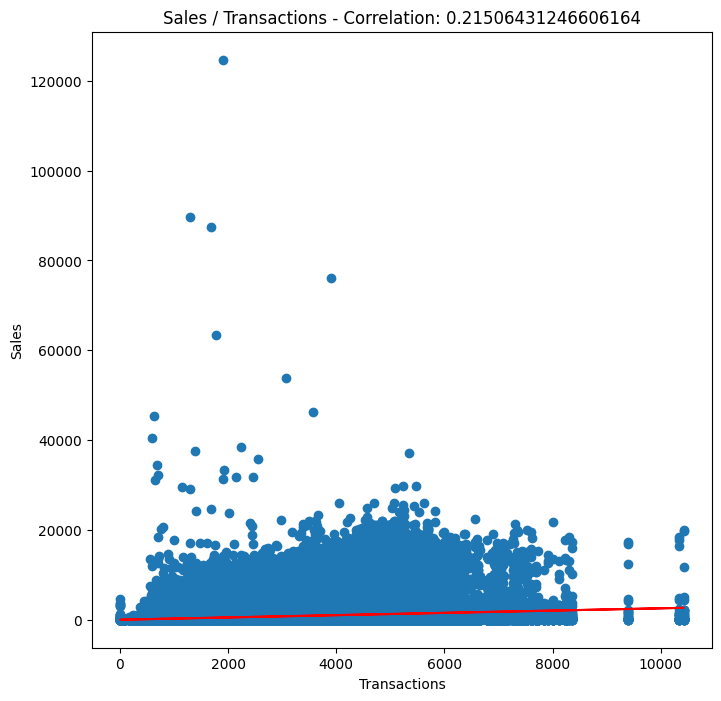

In [159]:
temp = merged_transaction_df.copy()
temp = temp.groupby('date').agg({'transactions':'sum', 'sales':'sum'}).reset_index()
correlation = temp['transactions'].corr(temp['sales'])
plt.figure(figsize=(8, 8))
plt.scatter(merged_transaction_df['transactions'], merged_transaction_df['sales'])
plt.title(f"Sales / Transactions - Correlation: {correlation}")
plt.xlabel("Transactions")
plt.ylabel("Sales")

# Calculate the coefficients of the polynomial trend line
coefficients = np.polyfit(merged_transaction_df['transactions'], merged_transaction_df['sales'], 1)
trend_line = np.polyval(coefficients, merged_transaction_df['transactions'])

# Plot the trend line
plt.plot(merged_transaction_df['transactions'], trend_line, color='red')

plt.show()



##### Visualize Correlation between Transactions and Sales by Store

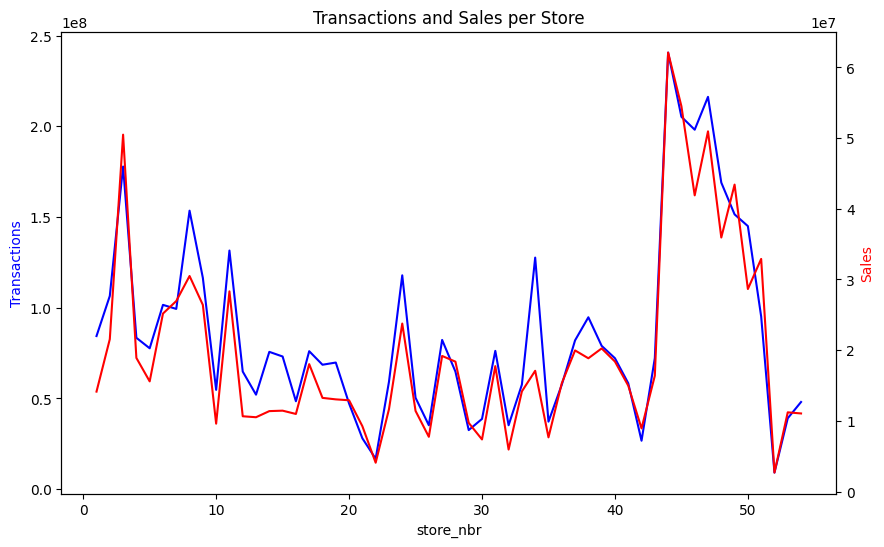

In [164]:
temp = merged_transaction_df.copy()
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot transactions per store
sns.lineplot(data=temp.groupby("store_nbr").agg({"transactions": "sum"}).reset_index(), x="store_nbr", y="transactions", ax=ax1, color='blue')
ax1.set_ylabel('Transactions', color='blue')
# Create a second y-axis for sales per store
ax2 = ax1.twinx()
sns.lineplot(data=temp.groupby("store_nbr").agg({"sales": "sum"}).reset_index(), x="store_nbr", y="sales", ax=ax2, color='red')
ax2.set_ylabel('Sales', color='red')
plt.title('Transactions and Sales per Store')
plt.show()

## Integrating Information about Holidays into Main Dataset

### Loading Holiday Dataset

In [179]:
holiday_dataset =  pd.read_parquet('../data/store_sales/holidays_events.parquet')
display(holiday_dataset)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


### Printing general Information

In [180]:
print("---------------------------------------------------------")
print(holiday_dataset.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(holiday_dataset.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
---------------------------------------------------------
Missing Value Count:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
None
---------------------------------------------------------


### Converting Date Column to DateTime

In [182]:
holiday_dataset["date"] = pd.to_datetime(holiday_dataset["date"])

### Plot Holiday Count by Region

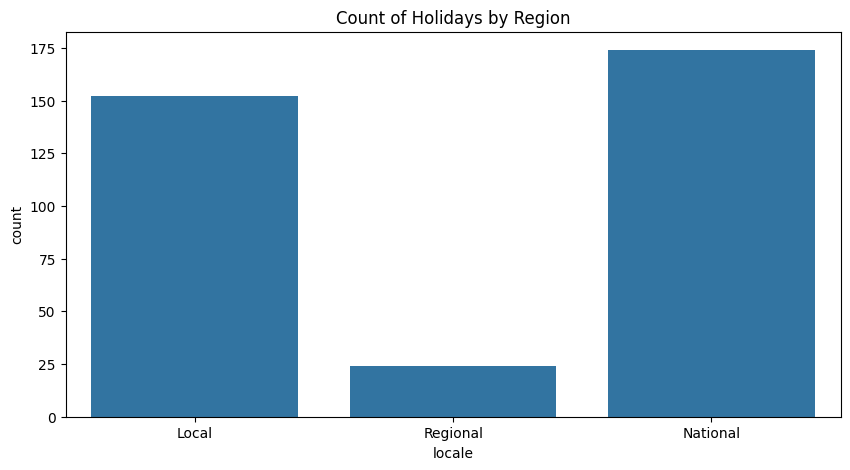

In [183]:
plt.figure(figsize=(10, 5))
sns.countplot(data=holiday_dataset, x='locale')
plt.title('Count of Holidays by Region')
plt.show()

### Drop holidays which have been shifted to another day

In [184]:
holiday_dataset = holiday_dataset[holiday_dataset['transferred'] == False]
print(holiday_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         338 non-null    datetime64[ns]
 1   type         338 non-null    object        
 2   locale       338 non-null    object        
 3   locale_name  338 non-null    object        
 4   description  338 non-null    object        
 5   transferred  338 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 16.2+ KB
None


### Dropping unwanted Columns and renaming others

In [185]:
holiday_dataset = holiday_dataset.drop(columns=["transferred", "description", "type"])
holiday_dataset = holiday_dataset.rename(columns={"locale": "holiday_region", "locale_name": "holiday_region_name"})

### Merging Holiday Dataset into Main Dataset

In [186]:
holiday_merged_df = pd.merge(merged_transaction_df, holiday_dataset, on="date", how="left")
print("---------------------------------------------------------")
print(holiday_merged_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(holiday_merged_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809125 entries, 0 to 2809124
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int64         
 11  holiday_region       object        
 12  holiday_region_name  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 278.6+ MB
None
---------------------------------------------------------
Missing Value Count:
id                           0
date            

### Filling missing Values with 0

In [188]:
holiday_merged_df = holiday_merged_df.fillna(0)
print(print(holiday_merged_df.isna().sum()))

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
type                   0
cluster                0
transactions           0
holiday_region         0
holiday_region_name    0
dtype: int64
None


## Integrating Information about National Inflation into Dataset

### Importing Global Inflation Dataset

In [195]:
global_inflation_df = pd.read_csv('../data/global_inflation_data.csv')
display(global_inflation_df)

,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual average inflation (consumer prices) rate,13.4,22.2,18.2,15.9,20.4,8.7,-2.1,18.4,...,-0.66,4.38,4.98,0.63,2.3,5.44,5.06,13.71,9.1,NaN
1,Albania,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.90,1.30,2.00,2.00,1.4,1.60,2.00,6.70,4.8,4.0
2,Algeria,Annual average inflation (consumer prices) rate,9.7,14.6,6.6,7.8,6.3,10.4,14.0,5.9,...,4.80,6.40,5.60,4.30,2.0,2.40,7.20,9.30,9.0,6.8
3,Andorra,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.10,-0.40,2.60,1.00,0.5,0.10,1.70,6.20,5.2,3.5
4,Angola,Annual average inflation (consumer prices) rate,46.7,1.4,1.8,1.8,1.8,1.8,1.8,1.8,...,9.20,30.70,29.80,19.60,17.1,22.30,25.80,21.40,13.1,22.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vietnam,Annual average inflation (consumer prices) rate,25.2,69.6,95.4,49.5,64.9,91.6,453.5,360.4,...,0.60,2.70,3.50,3.50,2.8,3.20,1.80,3.20,3.4,3.4
192,West Bank and Gaza,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.40,-0.20,0.20,-0.20,1.6,-0.70,1.20,3.70,3.4,2.7
193,Yemen,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.00,21.30,30.40,33.60,15.7,21.70,31.50,29.50,14.9,17.3
194,Zambia,Annual average inflation (consumer prices) rate,11.7,14.0,12.5,19.7,20.0,37.4,48.0,43.0,...,10.10,17.90,6.60,7.50,9.2,15.70,22.00,11.00,10.6,9.6


### Printing general Information

In [196]:
print("---------------------------------------------------------")
print(global_inflation_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(global_inflation_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    196 non-null    object 
 1   indicator_name  196 non-null    object 
 2   1980            140 non-null    float64
 3   1981            144 non-null    float64
 4   1982            145 non-null    float64
 5   1983            145 non-null    float64
 6   1984            145 non-null    float64
 7   1985            145 non-null    float64
 8   1986            145 non-null    float64
 9   1987            147 non-null    float64
 10  1988            147 non-null    float64
 11  1989            147 non-null    float64
 12  1990            150 non-null    float64
 13  1991            155 non-null    float64
 14  1992            158 non-null    float64
 15  1993            169 non-null    float64
 16  1994            171 no

### Selecting only values for Ecuador

In [201]:
ecuador_inflation_df = global_inflation_df[global_inflation_df['country_name'] == 'Ecuador']
display(ecuador_inflation_df.head())

,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
50,Ecuador,Annual average inflation (consumer prices) rate,13.0,16.4,16.3,48.4,31.2,28.0,23.0,29.5,...,4.0,1.7,0.4,-0.2,0.3,-0.3,0.1,3.5,2.3,1.8


### Transforming DataFrame into usable Format

In [202]:
ecuador_inflation_df = ecuador_inflation_df.transpose()
ecuador_inflation_df = ecuador_inflation_df.iloc[2:]
ecuador_inflation_df = ecuador_inflation_df.reset_index()
ecuador_inflation_df.columns = ['date', 'inflation_ecuador']
ecuador_inflation_df["date"] = pd.to_datetime(ecuador_inflation_df["date"])
display(ecuador_inflation_df.head())

,date,inflation_ecuador
0,1980-01-01,13.0
1,1981-01-01,16.4
2,1982-01-01,16.3
3,1983-01-01,48.4
4,1984-01-01,31.2


### Selecting only relevant date range

In [203]:
ecuador_inflation_df = ecuador_inflation_df[(ecuador_inflation_df['date'] >= holiday_merged_df["date"].min()) & (ecuador_inflation_df['date'] <= holiday_merged_df['date'].max())] 
ecuador_inflation_df = ecuador_inflation_df.reset_index(drop=True)
display(ecuador_inflation_df.head())

,date,inflation_ecuador
0,2013-01-01,2.7
1,2014-01-01,3.6
2,2015-01-01,4.0
3,2016-01-01,1.7
4,2017-01-01,0.4


### Plotting relative Inflation over the Years

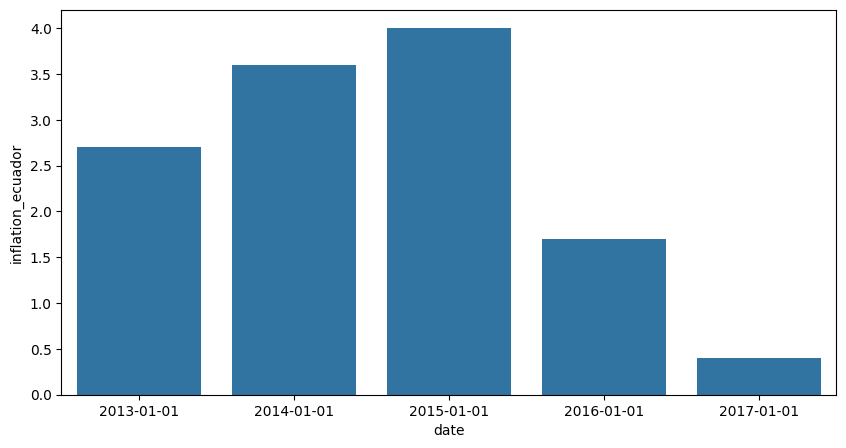

In [205]:
plt.figure(figsize=(10, 5))
sns.barplot(data=ecuador_inflation_df, x='date', y='inflation_ecuador')
plt.show()

### Merging Ecuador Inflation Dataset into Main Dataset

In [206]:
ecuador_inflation_merged_df = holiday_merged_df.merge(ecuador_inflation_df, how="left", on="date")
print("---------------------------------------------------------")
print(ecuador_inflation_merged_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(ecuador_inflation_merged_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809125 entries, 0 to 2809124
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int64         
 11  holiday_region       object        
 12  holiday_region_name  object        
 13  inflation_ecuador    object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(7)
memory usage: 300.0+ MB
None
---------------------------------------------------------
Missing Value Count:
id    

### Filling Missing Values using Forward Fill

In [208]:
pd.set_option('future.no_silent_downcasting', True)
ecuador_inflation_merged_df = ecuador_inflation_merged_df.ffill()
print(f"NaN values in column inflation_ecuador: {ecuador_inflation_merged_df['inflation_ecuador'].isnull().sum()}")

NaN values in column inflation_ecuador: 0


### Plotting Yearly Sales against Inflation

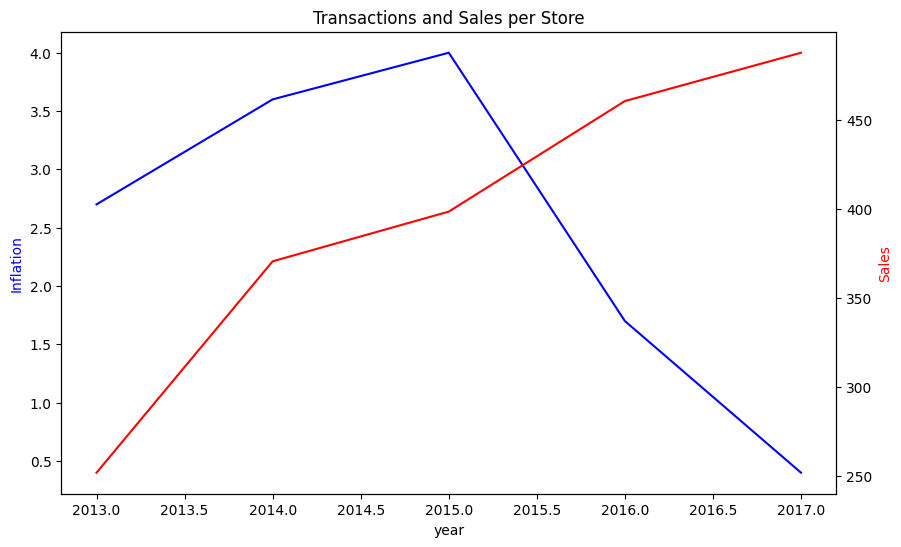

In [212]:
temp = ecuador_inflation_merged_df.copy()
temp["year"] = temp["date"].dt.year
temp = temp.groupby("year").agg({"inflation_ecuador": "mean", "sales":"mean"}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot transactions per store
sns.lineplot(data=temp.groupby("year").agg({"inflation_ecuador": "mean"}).reset_index(), x="year", y="inflation_ecuador", ax=ax1, color='blue')
ax1.set_ylabel('Inflation', color='blue')
# Create a second y-axis for sales per store
ax2 = ax1.twinx()
sns.lineplot(data=temp.groupby("year").agg({"sales": "mean"}).reset_index(), x="year", y="sales", ax=ax2, color='red')
ax2.set_ylabel('Sales', color='red')
plt.title('Inflation and Sales per Store')
plt.show()

## Adding Information about Oil Prices to Dataset

### Importing Oil Dataset

In [213]:
oil_price_df = pd.read_parquet('../data/store_sales/oil.parquet')
display(oil_price_df.head())

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### Printing general Information about Dataset

In [214]:
print("---------------------------------------------------------")
print(oil_price_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(oil_price_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
---------------------------------------------------------
Missing Value Count:
date           0
dcoilwtico    43
dtype: int64
None
---------------------------------------------------------


### Converting date and renaming column

In [215]:
oil_price_df["date"] = pd.to_datetime(oil_price_df["date"])
oil_price_df = oil_price_df.rename(columns={"dcoilwtico": "oil_price"})
print(oil_price_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


### Merging Oil Price Dataset with Main Dataset 

In [217]:
oil_price_merged_df = ecuador_inflation_merged_df.merge(oil_price_df, how="left", on="date")
print("---------------------------------------------------------")
print(oil_price_merged_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(oil_price_merged_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809125 entries, 0 to 2809124
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int64         
 11  holiday_region       object        
 12  holiday_region_name  object        
 13  inflation_ecuador    float64       
 14  oil_price            float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 321.5+ MB
None
--------------------------------------------

### Imputing NaN Values

#### Filling NaNs on weekends by using forward fill

In [218]:
oil_price_merged_df = oil_price_merged_df.ffill()
print(f"NaN values in column oil_price: {oil_price_merged_df['oil_price'].isnull().sum()}")

NaN values in column oil_price: 33


#### Checking which dates are still missing

In [219]:
missing_dates = oil_price_merged_df[oil_price_merged_df['oil_price'].isnull()]['date'].unique()
print(missing_dates[0])

2013-01-01 00:00:00


#### Filling first date using backwards fill

In [220]:
oil_price_merged_df = oil_price_merged_df.bfill()
print(f"NaN values in column oil_price: {oil_price_merged_df['oil_price'].isnull().sum()}")

NaN values in column oil_price: 0


### Visualizing Correlation between Oil Price and Sales

#### Oil Price and Sales over Time as LinePlot

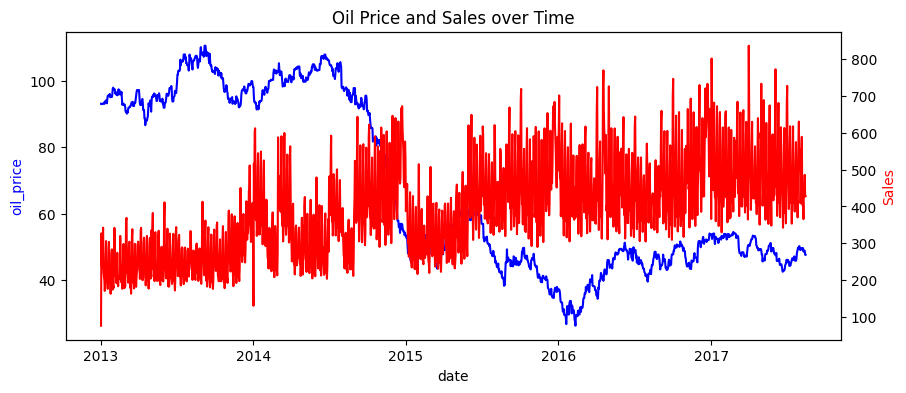

In [228]:
temp = oil_price_merged_df.copy()
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot transactions per store
sns.lineplot(data=temp.groupby("date").agg({"oil_price": "mean"}).reset_index(), x="date", y="oil_price", ax=ax1, color='blue')
ax1.set_ylabel('oil_price', color='blue')
# Create a second y-axis for sales per store
ax2 = ax1.twinx()
sns.lineplot(data=temp.groupby("date").agg({"sales": "mean"}).reset_index(), x="date", y="sales", ax=ax2, color='red')
ax2.set_ylabel('Sales', color='red')
plt.title('Oil Price and Sales over Time')
plt.show()

#### Oil Price / Sales Scatter Plot

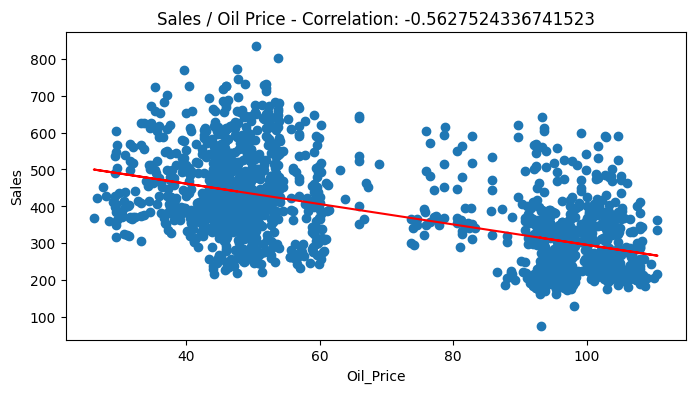

In [248]:
temp = oil_price_merged_df.copy()
temp = temp[['date', 'sales', 'oil_price']].groupby('date').mean().reset_index()
correlation = temp['oil_price'].corr(temp['sales'])
plt.figure(figsize=(8, 4))
plt.scatter(temp['oil_price'], temp['sales'])
plt.title(f"Sales / Oil Price - Correlation: {correlation}")
plt.xlabel("Oil_Price")
plt.ylabel("Sales")

# Calculate the coefficients of the polynomial trend line
coefficients = np.polyfit(temp['oil_price'], temp['sales'], 1)
trend_line = np.polyval(coefficients, temp['oil_price'])

# Plot the trend line
plt.plot(temp['oil_price'], trend_line, color='red')

plt.show()

## Adding Information about general USD Inflation per Month

### Loading USD Monthly Inflation DataFrame

In [236]:
usd_inflation_df = pd.read_csv('../data/inflation_per_month.csv')
display(usd_inflation_df.head())

,DATE,CPIUFDNS_PC1
0,1914-01-01,6.18557
1,1914-02-01,4.16667
2,1914-03-01,2.08333
3,1914-04-01,-1.03093
4,1914-05-01,1.04167


### Printing general Information

In [237]:
print("---------------------------------------------------------")
print(usd_inflation_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(usd_inflation_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1310 non-null   object 
 1   CPIUFDNS_PC1  1310 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.6+ KB
None
---------------------------------------------------------
Missing Value Count:
DATE            0
CPIUFDNS_PC1    0
dtype: int64
None
---------------------------------------------------------


### Converting Date and Renaming Values

In [239]:
usd_inflation_df["date"] = pd.to_datetime(usd_inflation_df["DATE"])
usd_inflation_df = usd_inflation_df.drop(["DATE"], axis=1)
usd_inflation_df = usd_inflation_df.rename(columns={"CPIUFDNS_PC1": "inflation_usd"})

### Filtering for relevant Dates

In [240]:
usd_inflation_df = usd_inflation_df[(usd_inflation_df['date'] >= oil_price_merged_df["date"].min()) & (usd_inflation_df['date'] <= oil_price_merged_df['date'].max())]
usd_inflation_df = usd_inflation_df.reset_index(drop=True)
print(usd_inflation_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   inflation_usd  56 non-null     float64       
 1   date           56 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB
None


### Merging Monthly USD Inflation with Main Dataset

In [244]:
usd_inflation_merged_df = oil_price_merged_df.merge(usd_inflation_df, how="left", on="date")
print("---------------------------------------------------------")
print(usd_inflation_merged_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(usd_inflation_merged_df.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809125 entries, 0 to 2809124
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int64         
 11  holiday_region       object        
 12  holiday_region_name  object        
 13  inflation_ecuador    float64       
 14  oil_price            float64       
 15  inflation_usd        float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(6)
memory usage: 342.9+ MB
None
---

#### Imputing Missing Data

In [245]:
usd_inflation_merged_df = usd_inflation_merged_df.ffill()
print(f"NaN values in column inflation_usd: {usd_inflation_merged_df['inflation_usd'].isnull().sum()}")

NaN values in column inflation_usd: 0


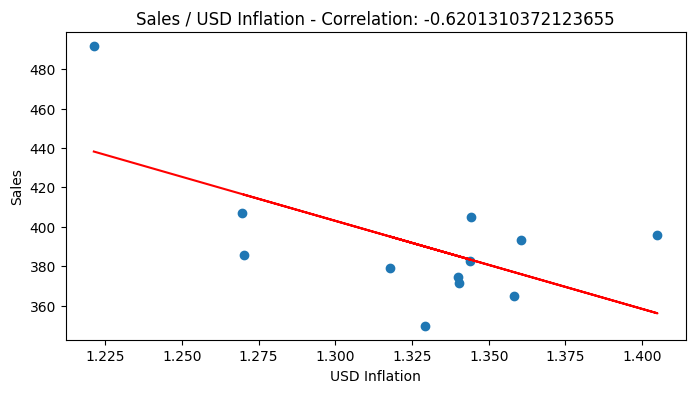

In [247]:
temp = usd_inflation_merged_df.copy()
temp["month"] = temp["date"].dt.month
temp = temp[['month', 'sales', 'inflation_usd']].groupby('month').mean().reset_index()
correlation = temp['inflation_usd'].corr(temp['sales'])
plt.figure(figsize=(8, 4))
plt.scatter(temp['inflation_usd'], temp['sales'])
plt.title(f"Sales / USD Inflation - Correlation: {correlation}")
plt.xlabel("USD Inflation")
plt.ylabel("Sales")

# Calculate the coefficients of the polynomial trend line
coefficients = np.polyfit(temp['inflation_usd'], temp['sales'], 1)
trend_line = np.polyval(coefficients, temp['inflation_usd'])
# Plot the trend line
plt.plot(temp['inflation_usd'], trend_line, color='red')

plt.show()

## Adding Information about USD/EUR Exchange Rates

### Importing Currency Exchange Data

In [249]:
currency_parquet = pd.read_parquet('../data/forex.parquet')
display(currency_parquet)

,slug,date,open,high,low,close,currency
0,GBP/EGP,2001-04-10,5.580900,5.594700,5.594700,5.594700,EGP
1,GBP/EGP,2001-06-04,5.475170,5.493900,5.493900,5.493900,EGP
2,GBP/EGP,2001-08-01,5.679900,5.654300,5.654300,5.654300,EGP
3,GBP/EGP,2002-07-29,7.217000,7.217000,7.217000,7.217000,EGP
4,GBP/EGP,2003-01-02,7.424290,7.389900,7.389900,7.389900,EGP
...,...,...,...,...,...,...,...
1453030,USD/MXN,2021-08-24,20.317129,20.360830,20.238400,20.317949,MXN
1453031,USD/MXN,2021-08-25,20.202400,20.347589,20.160601,20.206100,MXN
1453032,USD/MXN,2021-08-26,20.228861,20.384501,20.211901,20.216101,MXN
1453033,USD/MXN,2021-08-27,20.369301,20.423140,20.191200,20.366501,MXN


In [250]:
print("---------------------------------------------------------")
print(currency_parquet.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(currency_parquet.isna().sum()))
print("---------------------------------------------------------")

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453035 entries, 0 to 1453034
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   slug      1453035 non-null  object 
 1   date      1453035 non-null  object 
 2   open      1453035 non-null  float64
 3   high      1453035 non-null  float64
 4   low       1453035 non-null  float64
 5   close     1453035 non-null  float64
 6   currency  1453035 non-null  object 
dtypes: float64(4), object(3)
memory usage: 77.6+ MB
None
---------------------------------------------------------
Missing Value Count:
slug        0
date        0
open        0
high        0
low         0
close       0
currency    0
dtype: int64
None
---------------------------------------------------------


### Converting Date to DateTime

In [251]:
currency_parquet["date"] = pd.to_datetime(currency_parquet["date"])
print(currency_parquet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453035 entries, 0 to 1453034
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   slug      1453035 non-null  object        
 1   date      1453035 non-null  datetime64[ns]
 2   open      1453035 non-null  float64       
 3   high      1453035 non-null  float64       
 4   low       1453035 non-null  float64       
 5   close     1453035 non-null  float64       
 6   currency  1453035 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 77.6+ MB
None


### Selecting USD from the Dataset

In [253]:
us_currency = currency_parquet[currency_parquet['currency'] == 'USD']
print(us_currency.shape)

(46937, 7)


### Selecting dates relevant for train dataset

In [254]:
filtered_us_currency = us_currency[(us_currency['date'] >= usd_inflation_merged_df["date"].min()) & (us_currency['date'] <= usd_inflation_merged_df['date'].max())].reset_index(drop=True)
print(filtered_us_currency.shape)

(13247, 7)


### Selecting rows with exchange rate between EUR and USD

In [255]:
final_us_currency = filtered_us_currency[filtered_us_currency['slug'] == 'EUR/USD']
print(final_us_currency.shape)

(1204, 7)


### Dropping unused Columns and Renaming Data

In [256]:
final_us_currency  = final_us_currency.drop(['slug', "currency"], axis=1).reset_index(drop=True)
final_us_currency = final_us_currency.rename(columns={"open": "slug_eur_usd_open", "high": "slug_eur_usd_high", "low": "slug_eur_usd_low", "close": "slug_eur_usd_close"})
display(final_us_currency)

,date,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close
0,2013-01-01,1.320132,1.322401,1.319592,1.320132
1,2013-01-02,1.319784,1.329805,1.319435,1.319784
2,2013-01-03,1.318392,1.318913,1.308900,1.318218
3,2013-01-04,1.303101,1.306380,1.300052,1.303271
4,2013-01-07,1.306848,1.309929,1.302060,1.306745
...,...,...,...,...,...
1199,2017-08-09,1.175337,1.176028,1.169235,1.175461
1200,2017-08-10,1.176471,1.176471,1.170467,1.176152
1201,2017-08-11,1.176997,1.183180,1.174922,1.177024
1202,2017-08-14,1.182634,1.183999,1.177329,1.182550


### Merging Exchange Rate with Main Dataset

In [258]:
exchange_merged_df = usd_inflation_merged_df.merge(final_us_currency, how="left", on="date")
print(exchange_merged_df.isnull().sum())

id                          0
date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type                        0
cluster                     0
transactions                0
holiday_region              0
holiday_region_name         0
inflation_ecuador           0
oil_price                   0
inflation_usd               0
slug_eur_usd_open      812889
slug_eur_usd_high      812889
slug_eur_usd_low       812889
slug_eur_usd_close     812889
dtype: int64


In [259]:
weekday_missing = exchange_merged_df[exchange_merged_df['slug_eur_usd_open'].isnull() & (exchange_merged_df['date'].dt.weekday < 5)]
weekend_missing = exchange_merged_df[exchange_merged_df['slug_eur_usd_open'].isnull() & (exchange_merged_df['date'].dt.weekday >= 5)]

print("Weekdays with missing values:", len(weekday_missing))
print("Weekend days with missing values:", len(weekend_missing))


Weekdays with missing values: 3333
Weekend days with missing values: 809556


### Filling Missing Values on Weekends using Forward Fill

In [261]:
exchange_merged_df = exchange_merged_df.ffill()
print(exchange_merged_df.isnull().sum())

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
type                   0
cluster                0
transactions           0
holiday_region         0
holiday_region_name    0
inflation_ecuador      0
oil_price              0
inflation_usd          0
slug_eur_usd_open      0
slug_eur_usd_high      0
slug_eur_usd_low       0
slug_eur_usd_close     0
dtype: int64


### Visualizing Correlation between Exchange Rate and Sales

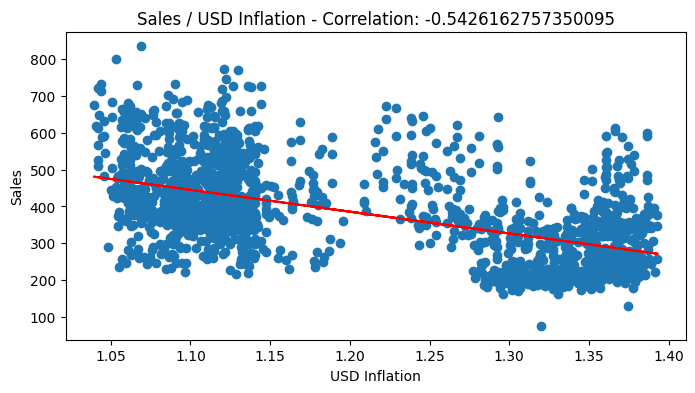

In [263]:
temp = exchange_merged_df.copy()

temp = temp[['date', 'sales', 'slug_eur_usd_open']].groupby('date').mean().reset_index()
correlation = temp['slug_eur_usd_open'].corr(temp['sales'])
plt.figure(figsize=(8, 4))
plt.scatter(temp['slug_eur_usd_open'], temp['sales'])
plt.title(f"Sales / USD/EUR Exchange Rate - Correlation: {correlation}")
plt.xlabel("USD/EUR Exchange Rate")
plt.ylabel("Sales")

# Calculate the coefficients of the polynomial trend line
coefficients = np.polyfit(temp['slug_eur_usd_open'], temp['sales'], 1)
trend_line = np.polyval(coefficients, temp['slug_eur_usd_open'])
# Plot the trend line
plt.plot(temp['slug_eur_usd_open'], trend_line, color='red')

plt.show()

## Preparing Data for Machine Learning Models

### Rename Columns after MLForecast Library Standard and Create "unique_id" Column

In [266]:
renamed_merge_df = exchange_merged_df.rename(columns={"date":"ds", "sales":"y"})
renamed_merge_df["unique_id"] = renamed_merge_df["store_nbr"].astype(str) + "_" + renamed_merge_df["family"]
print(renamed_merge_df.columns)

Index(['id', 'ds', 'store_nbr', 'family', 'y', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'transactions', 'holiday_region',
       'holiday_region_name', 'inflation_ecuador', 'oil_price',
       'inflation_usd', 'slug_eur_usd_open', 'slug_eur_usd_high',
       'slug_eur_usd_low', 'slug_eur_usd_close', 'unique_id'],
      dtype='object')


### One-Hot-Encoding Categorical Columns

#### One-Hot-Encoding Holiday Region

In [267]:
renamed_merge_df["is_national_holiday"] = (renamed_merge_df["holiday_region"] == "National").astype(int)
renamed_merge_df["is_regional_holiday"] = ((renamed_merge_df["holiday_region"] == "Regional") &  (renamed_merge_df["state"] == renamed_merge_df["holiday_region_name"])).astype(int)
renamed_merge_df["is_local_holiday"] = ((renamed_merge_df["holiday_region"] == "Local") & (renamed_merge_df["city"] == renamed_merge_df["holiday_region_name"])).astype(int)
display(renamed_merge_df)
print("---------------------------------------------------------")
print(renamed_merge_df.info())
print("---------------------------------------------------------")
print("Missing Value Count:")
print(print(renamed_merge_df.isna().sum()))
print("---------------------------------------------------------")

,id,ds,store_nbr,family,y,onpromotion,city,state,type,cluster,...,oil_price,inflation_usd,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,unique_id,is_national_holiday,is_regional_holiday,is_local_holiday
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,...,93.14,1.57952,1.320132,1.322401,1.319592,1.320132,25_AUTOMOTIVE,1,0,0
1,562,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,...,93.14,1.57952,1.320132,1.322401,1.319592,1.320132,25_BABY CARE,1,0,0
2,563,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,...,93.14,1.57952,1.320132,1.322401,1.319592,1.320132,25_BEAUTY,1,0,0
3,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,...,93.14,1.57952,1.320132,1.322401,1.319592,1.320132,25_BEVERAGES,1,0,0
4,565,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,...,93.14,1.57952,1.320132,1.322401,1.319592,1.320132,25_BOOKS,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809120,3000751,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,C,3,...,47.57,1.11982,1.177704,1.179245,1.168900,1.177579,54_POULTRY,0,0,0
2809121,3000752,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,C,3,...,47.57,1.11982,1.177704,1.179245,1.168900,1.177579,54_PREPARED FOODS,0,0,0
2809122,3000753,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,C,3,...,47.57,1.11982,1.177704,1.179245,1.168900,1.177579,54_PRODUCE,0,0,0
2809123,3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,C,3,...,47.57,1.11982,1.177704,1.179245,1.168900,1.177579,54_SCHOOL AND OFFICE SUPPLIES,0,0,0


---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809125 entries, 0 to 2809124
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   ds                   datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   y                    float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int64         
 11  holiday_region       object        
 12  holiday_region_name  object        
 13  inflation_ecuador    float64       
 14  oil_price            float64       
 15  inflation_usd        float64       
 16  slug_eur_usd_open    float64       
 17  slug_eur_usd_high    float64       
 18  slug

In [268]:
renamed_merge_df['is_holiday'] = (renamed_merge_df['is_national_holiday'] | renamed_merge_df['is_regional_holiday'] | renamed_merge_df['is_local_holiday']).astype(int)
national_holiday_sum = renamed_merge_df['is_national_holiday'].sum()
regional_holiday_sum = renamed_merge_df['is_regional_holiday'].sum()
local_holiday_sum = renamed_merge_df['is_local_holiday'].sum()
total_holiday_sum = national_holiday_sum + regional_holiday_sum + local_holiday_sum

is_holiday_count = renamed_merge_df['is_holiday'].sum()

print("Sum of all 1 values in is_national_holiday, is_regional_holiday, and is_local_holiday together:", total_holiday_sum)
print("Count of all 1 values in is_holiday:", is_holiday_count)

Sum of all 1 values in is_national_holiday, is_regional_holiday, and is_local_holiday together: 238128
Count of all 1 values in is_holiday: 238128


In [270]:
renamed_merge_df = renamed_merge_df.drop(columns=["holiday_region", "holiday_region_name"])

#### One-Hot-Encoding other categorical Values

In [273]:
encoded_merged_df = pd.get_dummies(renamed_merge_df, columns=['store_nbr', 'family', 'city', 'state'])
display(encoded_merged_df.head())

,id,ds,y,onpromotion,type,cluster,transactions,inflation_ecuador,oil_price,inflation_usd,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,561,2013-01-01,0.0,0,D,1,770,2.7,93.14,1.57952,...,False,False,False,False,False,False,False,True,False,False
1,562,2013-01-01,0.0,0,D,1,770,2.7,93.14,1.57952,...,False,False,False,False,False,False,False,True,False,False
2,563,2013-01-01,2.0,0,D,1,770,2.7,93.14,1.57952,...,False,False,False,False,False,False,False,True,False,False
3,564,2013-01-01,810.0,0,D,1,770,2.7,93.14,1.57952,...,False,False,False,False,False,False,False,True,False,False
4,565,2013-01-01,0.0,0,D,1,770,2.7,93.14,1.57952,...,False,False,False,False,False,False,False,True,False,False


## Overview over all Feature Correlations

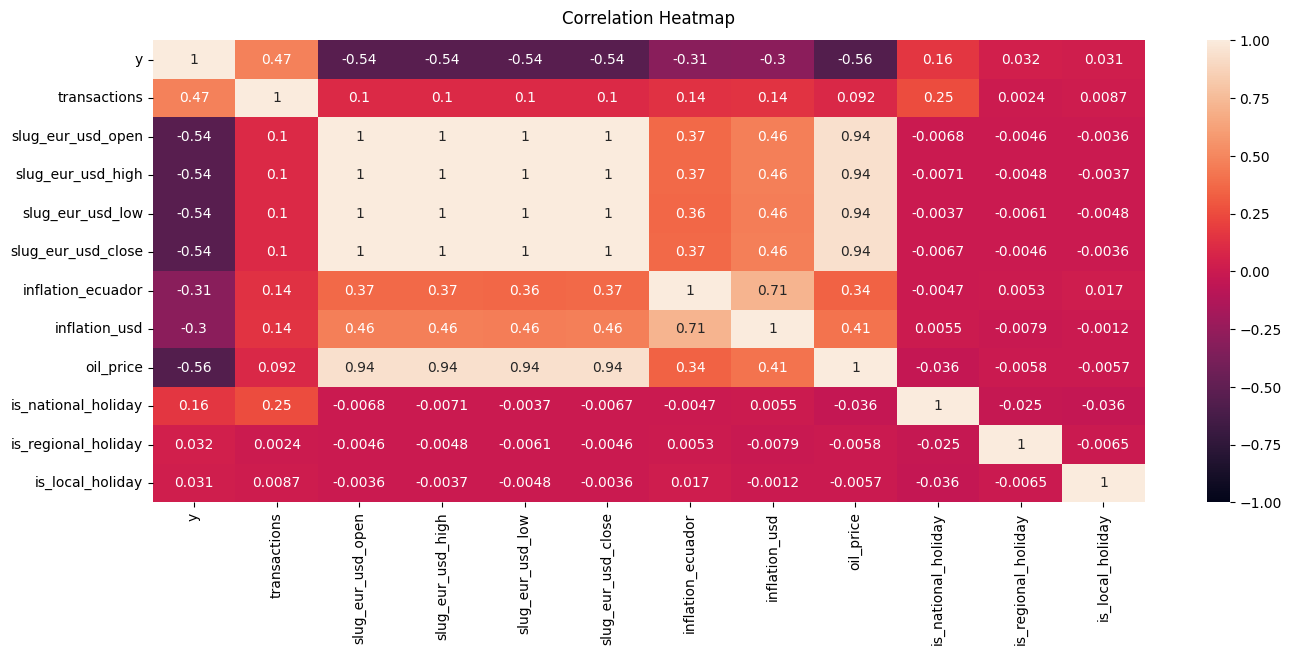

In [282]:
temp = encoded_merged_df.copy()
temp = temp[["y", "transactions", "slug_eur_usd_open", "slug_eur_usd_high", "slug_eur_usd_low", "slug_eur_usd_close", "inflation_ecuador", "inflation_usd", "oil_price", "is_national_holiday", "is_regional_holiday", "is_local_holiday", "ds"]].groupby("ds").mean().reset_index()
temp = temp.drop(columns=["ds"])
corr_df = temp.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

## Model Training

In [284]:
model_training_dataset = encoded_merged_df.copy()
print(f"Number of unique_ids: {model_training_dataset['unique_id'].nunique()}")

Number of unique_ids: 1782


### Split dataframe by type and cluster

In [285]:
split_dataframe_dict = {}
split_dataframe_dict["unsplit_dataframe"] = model_training_dataset.drop(columns=["type", "cluster"])

for type_value in model_training_dataset["type"].unique():
    split_dataframe_dict[f"type_{type_value}"] = model_training_dataset[model_training_dataset["type"] == type_value].drop(columns=["type", "cluster"])

for cluster_value in model_training_dataset["cluster"].unique():
    split_dataframe_dict[f"cluster_{cluster_value}"] = model_training_dataset[model_training_dataset["cluster"] == cluster_value].drop(columns=["type", "cluster"])

print(f"Number of DataFrames to train on: {len(split_dataframe_dict)}")

Number of DataFrames to train on: 23


### Preparing Method to Run MLForecast with

In here, we...
- ... define all possible Models with their respecting hyperparameter
- ... define all additional features MLForecast should create for us
- ... train and predict a model
- ... merge predicted values with actual values from validation dataset

In [101]:
def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def run_forecast(train, valid, h, config, model):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1,
                                n_jobs=-1
                                )]
    elif model == "RandomForestRegressor":
        models = [RandomForestRegressor(random_state=42,
                                        n_estimators=config["n_estimators"],
                                        max_depth=config["max_depth"],
                                        min_samples_split=config["min_samples_split"],
                                        min_samples_leaf=config["min_samples_leaf"],
                                        max_features=config["max_features"],
                                        bootstrap=config["bootstrap"]
                                        )]
    elif model == "DecisionTreeRegressor":
        models = [DecisionTreeRegressor(random_state=42,
                                        max_depth=config["max_depth"],
                                        min_samples_split=config["min_samples_split"],
                                        min_samples_leaf=config["min_samples_leaf"],
                                        max_features=config["max_features"]
                                        )]
    elif model == "GradientBoostingRegressor":
        models = [GradientBoostingRegressor(random_state=42,
                                            n_estimators=config["n_estimators"],
                                            learning_rate=config["learning_rate"],
                                            max_depth=config["max_depth"],
                                            min_samples_split=config["min_samples_split"],
                                            min_samples_leaf=config["min_samples_leaf"],
                                            max_features=config["max_features"]
                                            )]
    elif model == "LinearRegressor":
        models = [LinearRegression()]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    mlfc.fit(train)
    prediction = mlfc.predict(h=h)

    merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    return merged_prediction



### Custom Callback Function for Optuna

In [ ]:
def champion_callback(study, frozen_trial):

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

### Optuna Hyperparameter Optimization

In [ ]:
# possible models: "XGBRegressor", "LGBMRegressor", "RandomForestRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "LinearRegressor"

model = "LGBMRegressor"

optuna.logging.set_verbosity(optuna.logging.ERROR)

error_df = pd.DataFrame({
    "unique_id": model_training_dataset["unique_id"].unique(), 
    "msle": [float('inf')] * len(model_training_dataset["unique_id"].unique()),
    "mse": [float('inf')] * len(model_training_dataset["unique_id"].unique()),
    "mae": [float('inf')] * len(model_training_dataset["unique_id"].unique()),
    "r2": [float('inf')] * len(model_training_dataset["unique_id"].unique()),
    "mape": [float('inf')] * len(model_training_dataset["unique_id"].unique())
    })
best_predictions_df = pd.DataFrame()
    
for key, dataframe in split_dataframe_dict.items():

    print("current dataframe: " + key)
    start = time()

    dataframe.columns = [re.sub(r'\W+', '', col) for col in dataframe.columns]

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()

    def objective(trial):
        config = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "learning_rate": trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 50),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0),
            "lags": trial.suggest_int("lags", 14, 56, step=7),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.1, 1.0)
        }

        prediction = run_forecast(train, valid, h, config, model)
        prediction.loc[prediction[model] < 0, model] = 0
        error = math.sqrt(mean_squared_log_error(prediction['y'], prediction[model]))
        
        return error

    study = optuna.create_study(direction="minimize", storage="sqlite:////home/nikl/programming/fhdw/forecasting/ForecastingUniProject/db.sqlite3", 
                                study_name=f"MON_{model}_{key}", load_if_exists=True)
    study.optimize(objective, n_trials=25, callbacks=[champion_callback])

    prediction = run_forecast(train, valid, h, study.best_params, model)

    for unique_id in prediction["unique_id"].unique():
        if study.best_value < error_df[error_df["unique_id"] == unique_id]["msle"].iloc[0]:
            filtered_rows = prediction[prediction["unique_id"] == unique_id]
            try:
                best_predictions_df = best_predictions_df.drop(best_predictions_df[best_predictions_df["unique_id"] == unique_id].index, axis=0)
            except:
                print("Wasn't able to drop rows")
            best_predictions_df = pd.concat([best_predictions_df, filtered_rows], ignore_index=True)

            error_df.loc[error_df["unique_id"] == unique_id, "msle"] = study.best_value
            error_df.loc[error_df["unique_id"] == unique_id, "mse"] = mean_squared_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mae"] = mean_absolute_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "r2"] = r2_score(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

    print(f"Time: {(time()-start)/60}")
    

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

best_predictions_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_{model}_{formatted_datetime}_RMSLE.parquet")
error_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/error_{model}_{formatted_datetime}_RMSLE.parquet")

### LightGBM Visuals

In [ ]:
import math 
light_gbm_df = pd.read_parquet("/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_LGBMRegressor_2024-03-11_00-06-38.parquet")
light_gbm_df.loc[light_gbm_df["LGBMRegressor"] < 0, "LGBMRegressor"] = 0
print(math.sqrt(mean_squared_log_error(light_gbm_df['y'], light_gbm_df["LGBMRegressor"])))
px.scatter(light_gbm_df, x="LGBMRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for LGBMRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
store_1_prediction = light_gbm_df[light_gbm_df["unique_id"] == "3_AUTOMOTIVE"]
display(store_1_prediction)
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales")
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["LGBMRegressor"], mode="lines", name="Prediction")
fig.show()


### Decision Tree Visuals

In [ ]:
decision_tree_df = pd.read_parquet("/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_DecisionTreeRegressor_2024-03-11_18-04-50.parquet")
print(math.sqrt(mean_squared_log_error(decision_tree_df['y'], decision_tree_df["DecisionTreeRegressor"])))
px.scatter(decision_tree_df, x="DecisionTreeRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for DecisionTreeRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
store_1_prediction = decision_tree_df[decision_tree_df["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["DecisionTreeRegressor"], mode="lines", name="Prediction")
fig.show()

In [ ]:
store_1_prediction = decision_tree_df[decision_tree_df["unique_id"] == "1_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "1_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01" & store_1_validation["ds"] <= "2017-08-01"]

# Get the last date of the validation data
last_date = store_1_validation["ds"].max()

# Update the x-axis values of the prediction line
store_1_prediction.loc[store_1_prediction["ds"] > last_date, "ds"] = last_date

fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["DecisionTreeRegressor"], mode="lines", name="Prediction")
fig.show()


### XGBoost Visualization

In [ ]:
xgb_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_XGBRegressor_2024-03-12_01-23-53.parquet")
xgb_df.loc[xgb_df["XGBRegressor"] < 0, "XGBRegressor"] = 0
print(math.sqrt(mean_squared_log_error(xgb_df['y'], xgb_df["XGBRegressor"])))
px.scatter(xgb_df, x="XGBRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for XGBRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
store_1_prediction = xgb_df[xgb_df["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["XGBRegressor"], mode="lines", name="Prediction")
fig.show()

What to do next:

- Analyse verschiedener Modelle
- Guten plot einbauen der forecast zeigt
- Cross Validation einbauen
- Feature Importance einbauen
- Future Leakage Fix einbauen

Ideen für Feature Importance:
- Datensatz mit mlfc.preprocess(train) nur vorbereiten, nicht trainieren oder predicten
- Datensatz anschauen und überprüfen ob wie erwartet
- Datensatz direkt in LightGBM geben und da trainieren und predicten
- Prediction results mit Erwarteten Wert von MLForecast Training vergleichen
- Wenn gleich, dann lgb.plot_importance() machen und anschauen
- Am besten wäre es, wenn wir an die Daten direkt tabelarisch rankommen würden anstatt nur nen plot zu kriegen, damit wir selbst wieder One-Hot-Encodete features aufsummieren können
- Sowohl gain als auch split mal anschauen
- Gleiches für XGBoost einrichten

Idee für Plot:
- Daten für ein paar unique_ids rausfiltern
- Diese daten dann als Lineplot für y plotten
- Darüber dann die prediction legen

Idee für cross validation:
- Idk, einfach versuchen das iwi mit mlforecast cross validator durchzuboxen